# \HOG FEATURES EXTRACTION

In [ ]:
#@title Extract HOG Features
# HOG

import os
import cv2
import numpy as np
import pandas as pd

from tqdm import tqdm
from skimage import io, transform, feature, exposure,color
from skimage.feature import local_binary_pattern

dataset_path = "/content/drive/MyDrive/brain-tumor - Copy"
image_size = (256, 256)
classes = ["hybrid(G+P)", "Meningioma"]
csv_file_path = '/content/drive/MyDrive/hog_features1.csv'

# Define HOG parameters
orientations = 9
pixels_per_cell = (32, 32)
cells_per_block = (2, 2)

# Define a function to extract HOG features from an image
def extract_hog_features(image):
    image = io.imread(image)
    image = transform.resize(image, image_size)


    features = feature.hog(image, orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           block_norm='L2-Hys')

    return features

if not os.path.exists(csv_file_path):
    # Load and preprocess the dataset
    images_path = []
    labels = []

    # Extract HOG features for each image
    hog_features = []

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)

        for image_file in tqdm(image_files, total=len(image_files)):
            image_path = os.path.join(class_path, image_file)
            images_path.append(image_path)
            labels.append(i)
            # extract HOG features for the image
            hog_feature = extract_hog_features(image_path)
            hog_features.append(hog_feature)

    hog_features = np.array(hog_features)
    labels = np.array(labels)
    print('[hog_features]', hog_features.shape)
    print('[labels]', labels.shape)

    # Convert features and labels to a DataFrame
    features_df = pd.DataFrame(hog_features)
    labels_df = pd.DataFrame(labels, columns=['Label'])

    # Concatenate features and labels DataFrames
    df = pd.concat([features_df, labels_df], axis=1)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)

    print(f"Data saved to {csv_file_path}")

    print('features shape:', hog_features.shape)
    print('Labels shape:', labels.shape)
    print('[hog_features]', len(hog_features), hog_features[0], hog_features[-1])
    print('[labels]', len(labels), labels[:10], labels[-10:])


100%|██████████| 709/709 [00:27<00:00, 26.23it/s]


[hog_features] (3070, 1764)
[labels] (3070,)
Data saved to /content/drive/MyDrive/hog_features1.csv
features shape: (3070, 1764)
Labels shape: (3070,)
[hog_features] 3070 [0. 0. 0. ... 0. 0. 0.] [0.09711732 0.07940758 0.07542223 ... 0.01628546 0.04182442 0.0392592 ]
[labels] 3070 [0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1]


#KFOLD 10 FOLDS

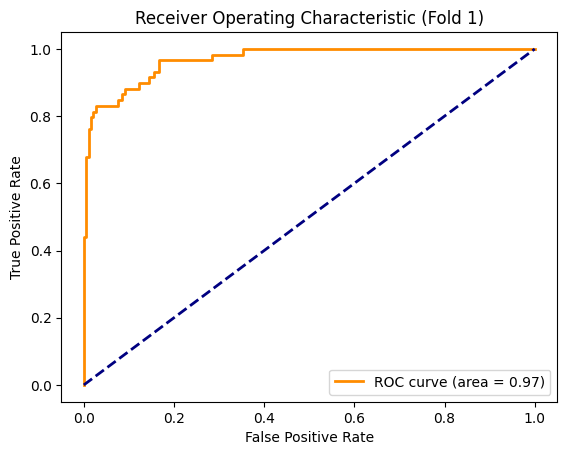

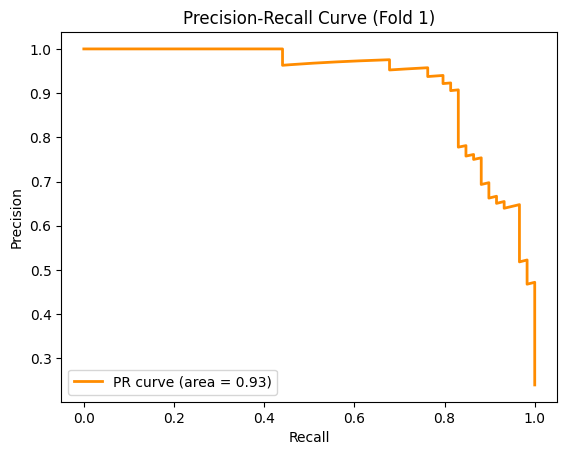

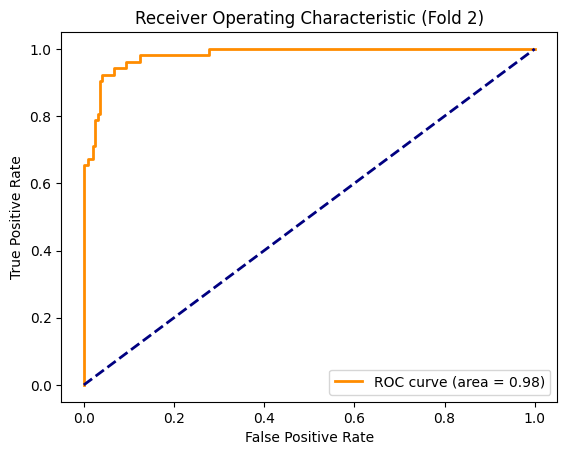

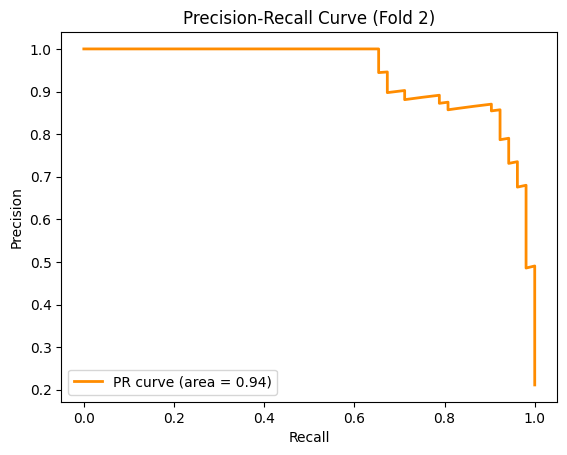

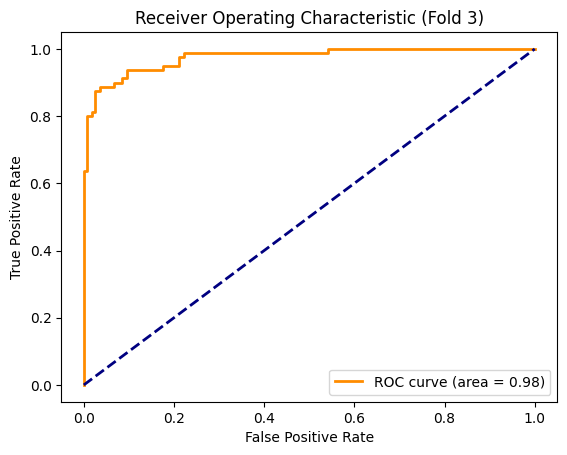

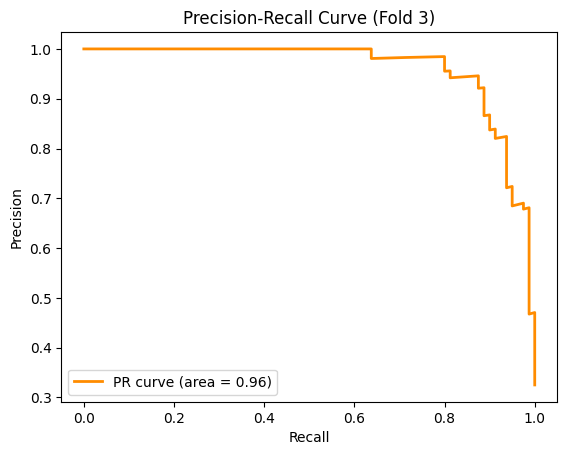

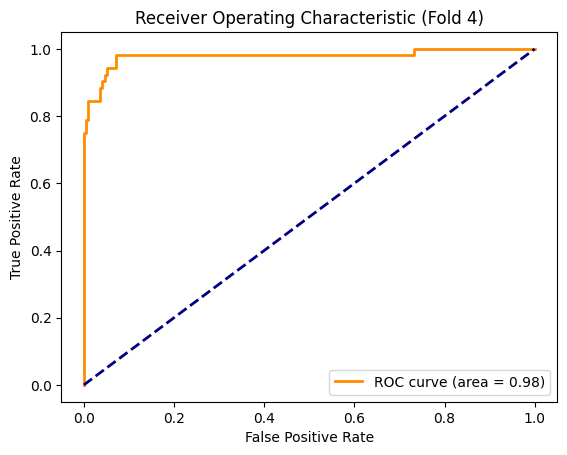

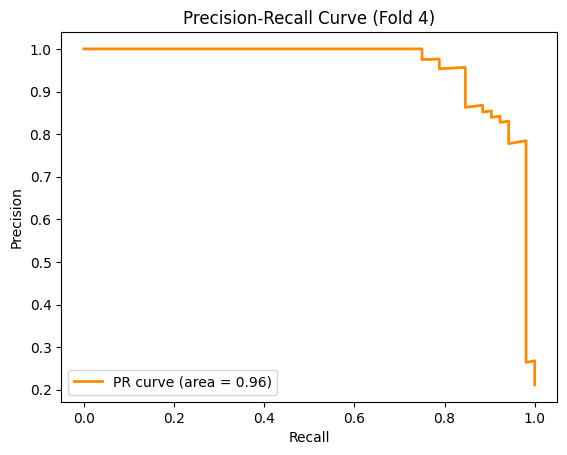

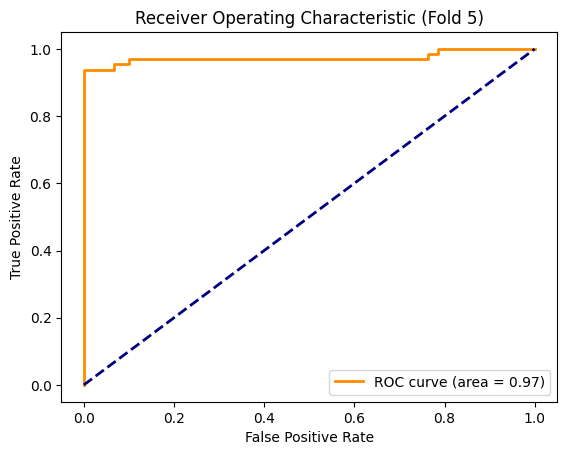

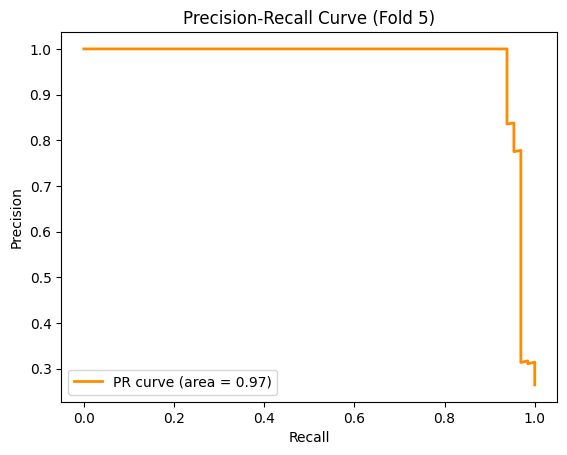

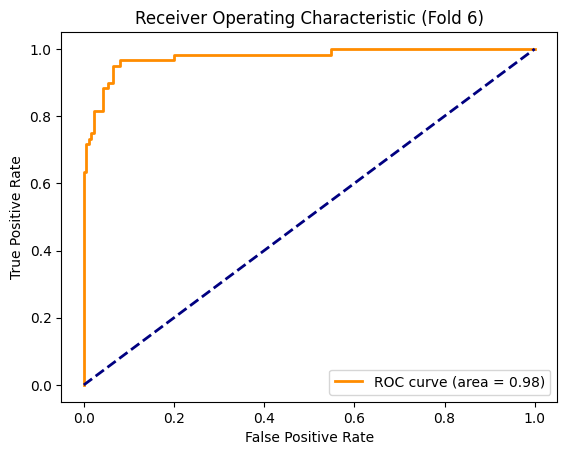

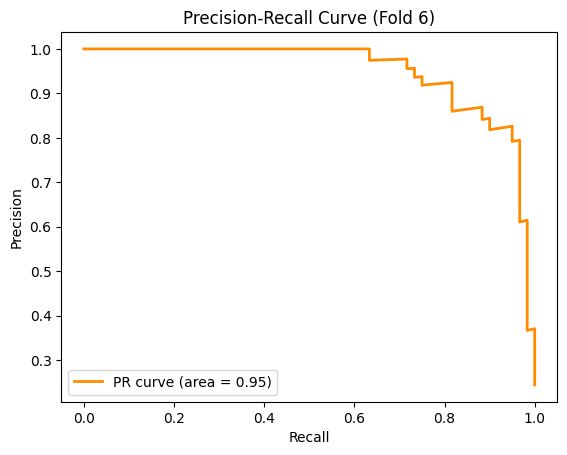

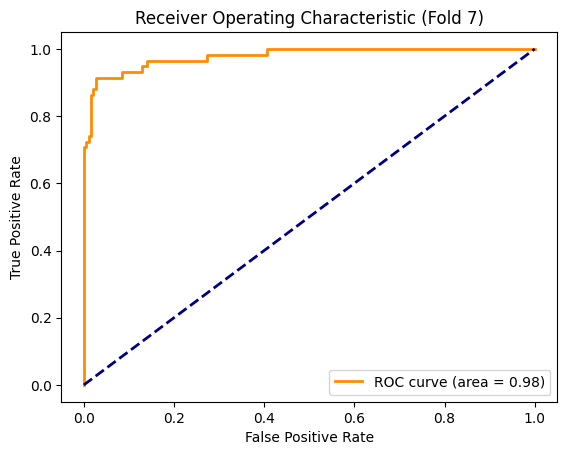

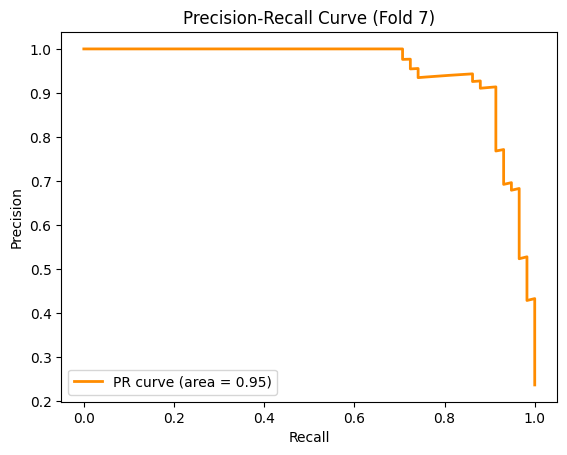

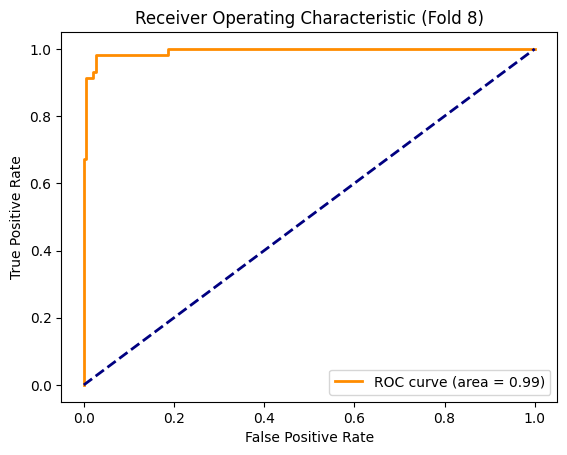

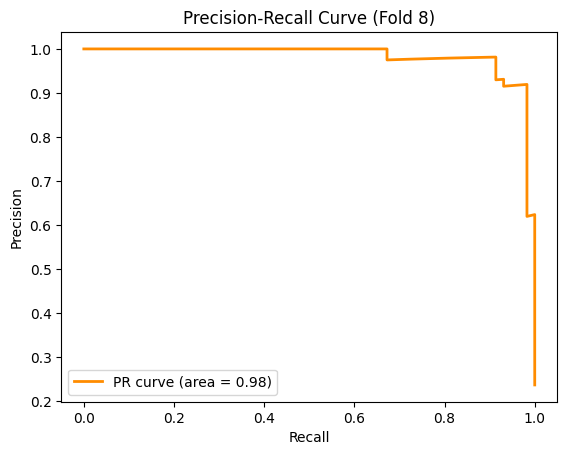

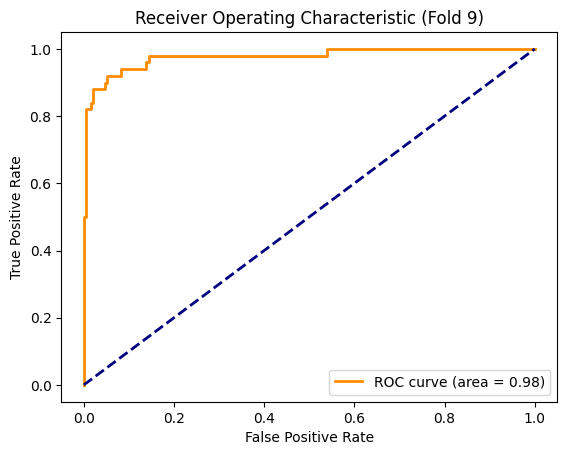

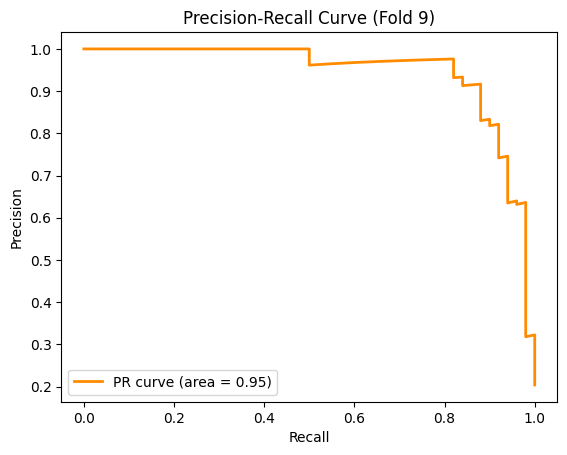

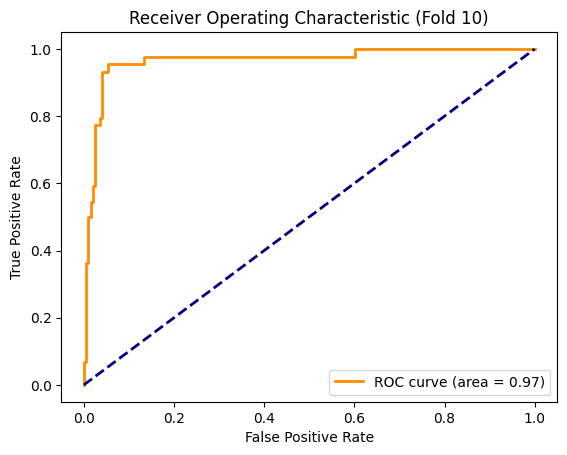

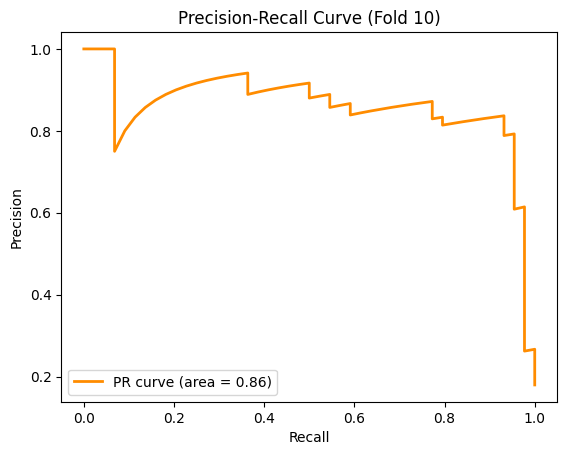

Fold 1 Results:
Accuracy: 0.9228
MCC Score: 0.7870
F1 Score: 0.8376
Recall (Sensitivity): 1.0000
Precision: 0.2408
Specificity: 0.9519
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       187
           1       0.84      0.83      0.84        59

    accuracy                           0.92       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.92      0.92      0.92       246

Confusion Matrix:
[[178   9]
 [ 10  49]]
------------------------------
Fold 2 Results:
Accuracy: 0.9512
MCC Score: 0.8587
F1 Score: 0.8889
Recall (Sensitivity): 1.0000
Precision: 0.2122
Specificity: 0.9588
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       194
           1       0.86      0.92      0.89        52

    accuracy                           0.95       246
   macro avg       0.92      0.94      0.93       246
weighted avg 

In [ ]:
#@title Train SVC on HOG Features

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    f1_score,
)
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load Data
csv_file_path = '/content/drive/MyDrive/hog_features1.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Split Data
X = df.drop('Label', axis=1)
y = df['Label']

# Split data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize K-Fold Cross-Validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 4: Initialize SVM Model with class_weight='balanced'
svm_model = SVC(kernel='poly', degree=3, probability=True)

# Initialize lists to store performance metrics for each fold
roc_scores = []
pr_scores = []
accuracy_scores = []
classification_reports = []
confusion_matrices = []
mcc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
specificity_scores = []
sensitivity_scores = []

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Initialize an empty confusion matrix
overall_confusion_matrix = np.zeros((2, 2), dtype=int)

# K-Fold Cross-Validation
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_val)):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_val)
    y_prob = svm_model.predict_proba(X_val)[:, 1]

    # Calculate metrics for this fold
    roc_auc = roc_auc_score(y_val, y_prob)
    roc_scores.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    pr_auc = auc(recall, precision)
    pr_scores.append(pr_auc)

    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

    class_report = classification_report(y_val, y_pred)
    classification_reports.append(class_report)

    conf_matrix = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(conf_matrix)

    overall_confusion_matrix += conf_matrix

    mcc = matthews_corrcoef(y_val, y_pred)
    mcc_scores.append(mcc)

    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

    sensitivity = recall[1]
    sensitivity_scores.append(sensitivity)

    precision_ = precision[1]
    precision_scores.append(precision_)

    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    specificity_scores.append(specificity)

    # Plot ROC Curve for this fold
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold_idx+1})')
    plt.legend(loc='lower right')

    # Plot PR Curve for this fold
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Fold {fold_idx+1})')
    plt.legend(loc='lower left')
    plt.show()

# Print the results for each fold
for fold_idx in range(len(accuracy_scores)):
    print(f'Fold {fold_idx+1} Results:')
    print(f'Accuracy: {accuracy_scores[fold_idx]:.4f}')
    print(f'MCC Score: {mcc_scores[fold_idx]:.4f}')
    print(f'F1 Score: {f1_scores[fold_idx]:.4f}')
    print(f'Recall (Sensitivity): {sensitivity_scores[fold_idx]:.4f}')
    print(f'Precision: {precision_scores[fold_idx]:.4f}')
    print(f'Specificity: {specificity_scores[fold_idx]:.4f}')
    print('Classification Report:')
    print(classification_reports[fold_idx])
    print('Confusion Matrix:')
    print(confusion_matrices[fold_idx])
    print('-' * 30)

# Calculate and print mean ROC AUC and PR AUC scores, mean Accuracy
mean_roc_score = sum(roc_scores) / len(roc_scores)
mean_pr_score = sum(pr_scores) / len(pr_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_mcc = sum(mcc_scores) / len(mcc_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)
mean_recall = sum(sensitivity_scores) / len(sensitivity_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_specificity = sum(specificity_scores) / len(specificity_scores)

print(f'Mean ROC AUC Score: {mean_roc_score:.4f}')
print(f'Mean PR AUC Score: {mean_pr_score:.4f}')
print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean MCC Score: {mean_mcc:.4f}')
print(f'Mean F1 Score: {mean_f1:.4f}')
print(f'Mean Recall (Sensitivity): {mean_recall:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Specificity: {mean_specificity:.4f}')

# Print the overall confusion matrix
print("Overall Confusion Matrix:")
print(overall_confusion_matrix)

# Train the model on the entire training set (all folds combined)
svm_model.fit(X_train_val, y_train_val)

# Evaluate the model on the test set
y_test_pred = svm_model.predict(X_test)
y_test_prob = svm_model.predict_proba(X_test)[:, 1]

# Calculate metrics for the test set
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate MCC (Matthews Correlation Coefficient) Score for the test set
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Calculate F1 Score for the test set
test_f1 = f1_score(y_test, y_test_pred)

# Calculate Specificity for the test set
test_specificity = test_conf_matrix[0, 0] / (test_conf_matrix[0, 0] + test_conf_matrix[0, 1])

# Print the test set results
print('\nTest Set Results:')
print(f'Test ROC AUC Score: {test_roc_auc:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test MCC Score: {test_mcc:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Specificity: {test_specificity:.4f}')
print('Test Classification Report:')
print(test_class_report)
print('Test Confusion Matrix:')
print(test_conf_matrix)


# LBP FEATURE EXTRACTION

In [ ]:
#@title Extract LBP Features
# LBP

import os
import pandas as pd
import numpy as np
import cv2
from skimage import io, transform, feature, exposure, color
from skimage.feature import local_binary_pattern

dataset_path = "/content/drive/MyDrive/brain-tumor - Copy"
image_size = (256, 256)
classes = ["hybrid(G+P)", "Meningioma"]
csv_file_path = '/content/drive/MyDrive/lbp_features1.csv'

# Define LBP parameters
radius = 1
n_points = 8 * radius

# Define a function to extract LBP features from an image
def extract_lbp_features(image):
    image = io.imread(image)
    image = transform.resize(image, image_size)

    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    return lbp_hist

if not os.path.exists(csv_file_path):
    # Load and preprocess the dataset
    images_path = []
    labels = []

    # Extract LBP features for each image
    lbp_features = []

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)

        for image_file in tqdm(image_files, total=len(image_files)):
            image_path = os.path.join(class_path, image_file)
            images_path.append(image_path)
            labels.append(i)
            # extract LBP features
            lbp_feature = extract_lbp_features(image_path)
            lbp_features.append(lbp_feature)

    lbp_features = np.array(lbp_features)
    labels = np.array(labels)

    # Convert features and labels to a DataFrame
    features_df = pd.DataFrame(lbp_features)
    labels_df = pd.DataFrame(labels, columns=['Label'])

    # Concatenate features and labels DataFrames
    df = pd.concat([features_df, labels_df], axis=1)

    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)
    print(f"Data saved to {csv_file_path}")

    print('features shape:', lbp_features.shape)
    print('Labels shape:', labels.shape)
    print('[lbp_features]', len(lbp_features), lbp_features[0], lbp_features[-1])
    print('[labels]', len(labels), labels[:10], labels[-10:])


100%|██████████| 709/709 [00:19<00:00, 36.79it/s]

Data saved to /content/drive/MyDrive/lbp_features1.csv
features shape: (3070, 10)
Labels shape: (3070,)
[lbp_features] 3070 [0.05697632 0.05784607 0.04615784 0.07577515 0.14183044 0.08239746
 0.04595947 0.05784607 0.33488464 0.10032654] [0.05149841 0.06399536 0.05729675 0.10005188 0.19837952 0.10403442
 0.05311584 0.06314087 0.21334839 0.09513855]
[labels] 3070 [0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1]


# KFOLD ON LBP FEATURES

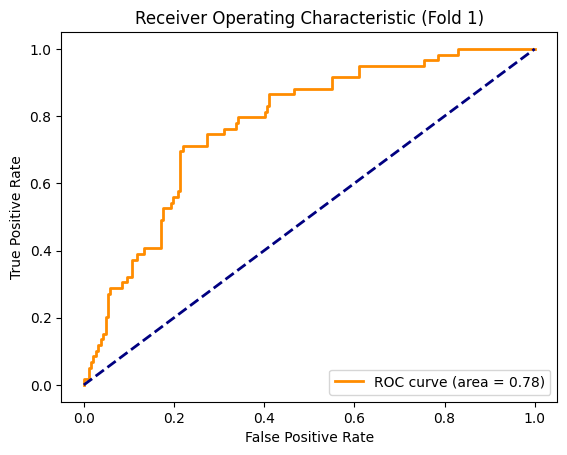

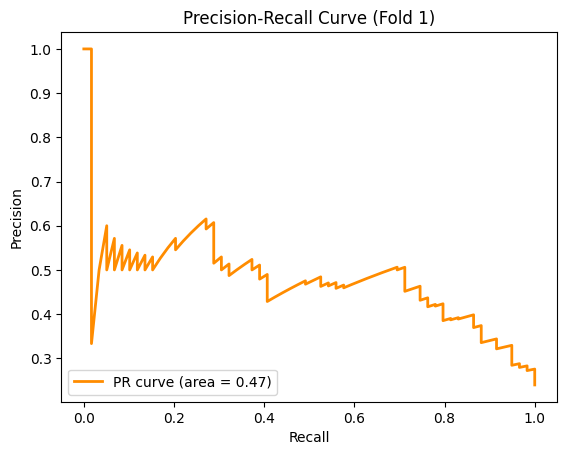

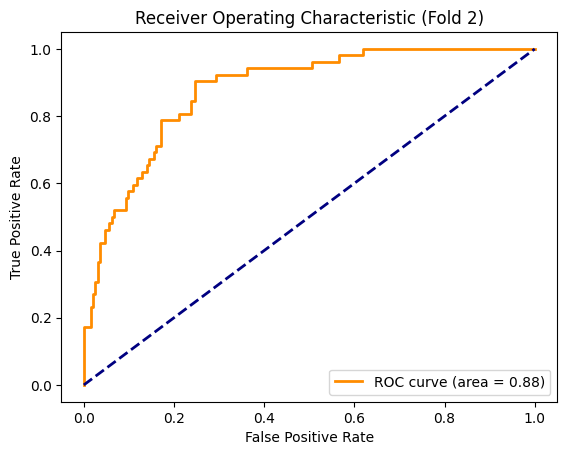

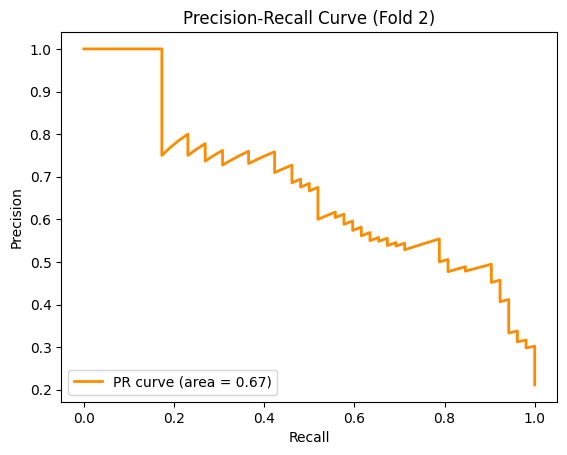

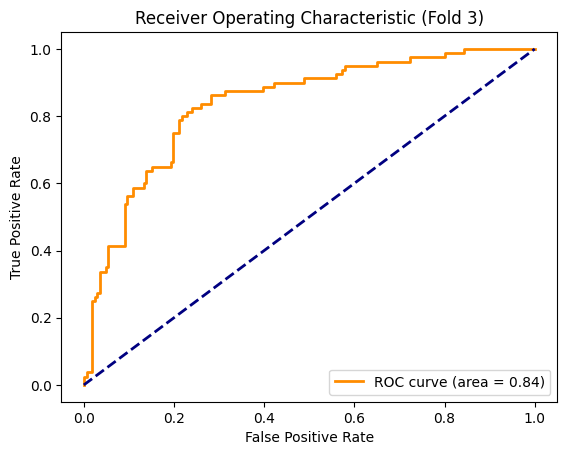

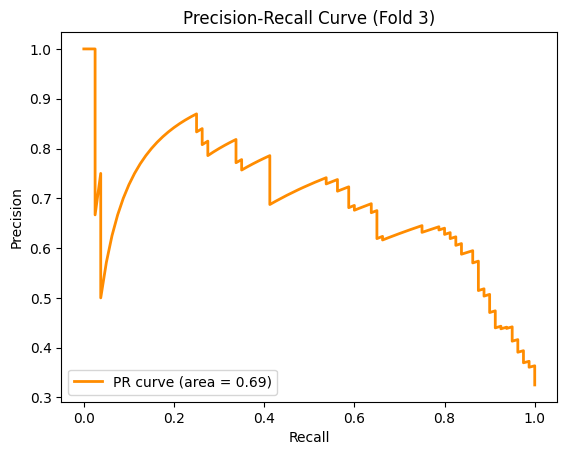

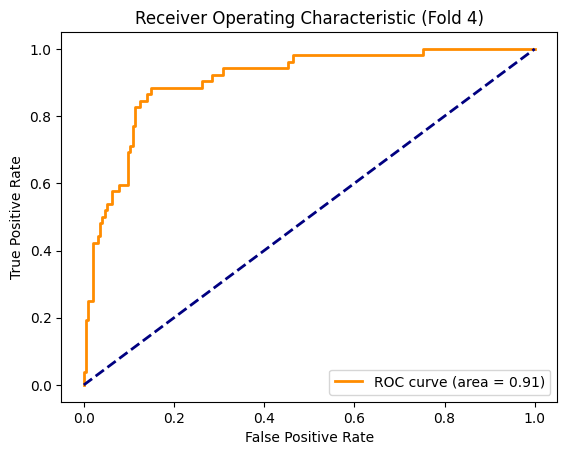

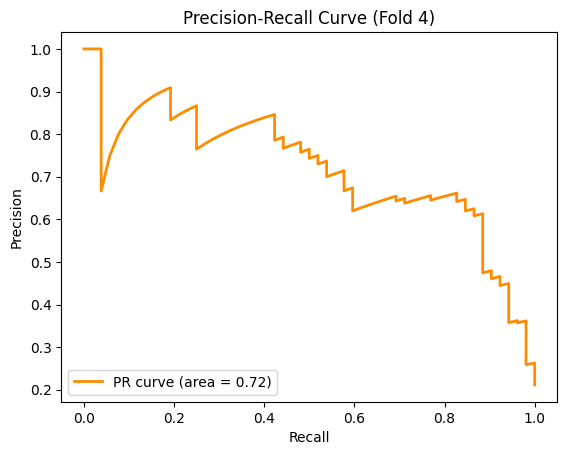

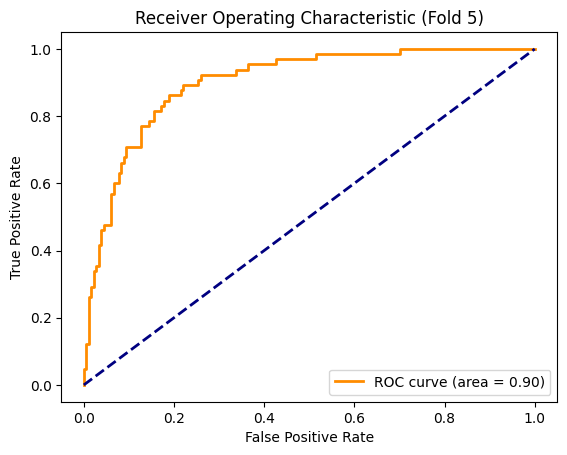

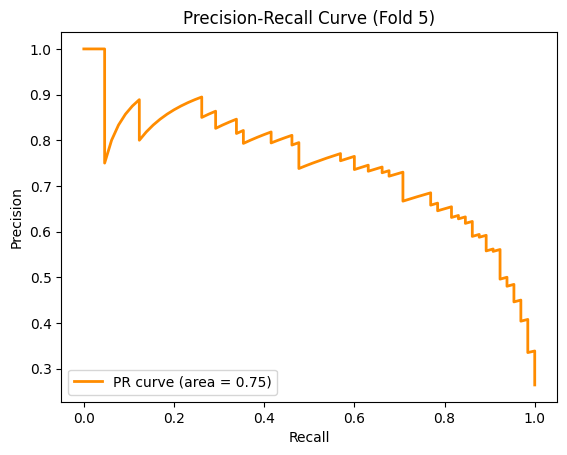

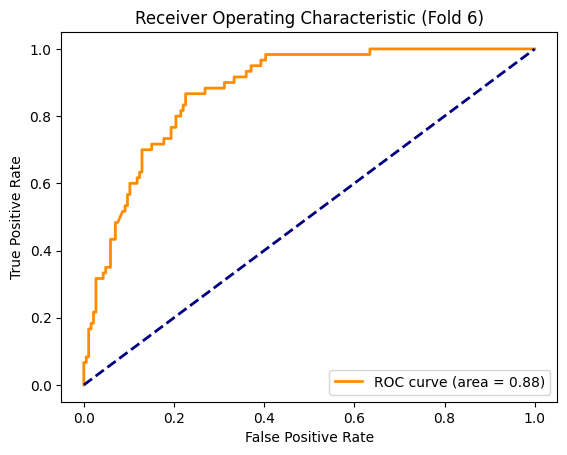

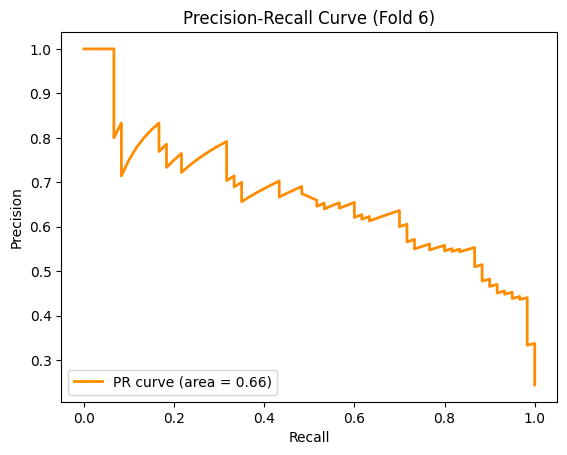

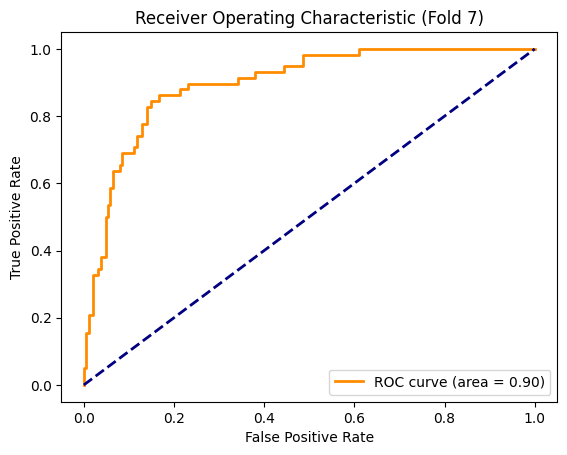

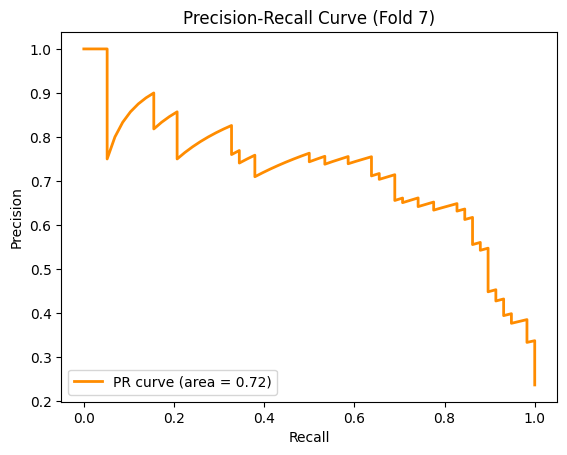

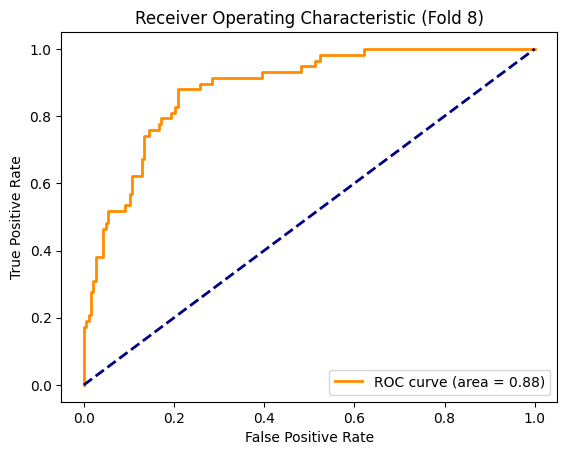

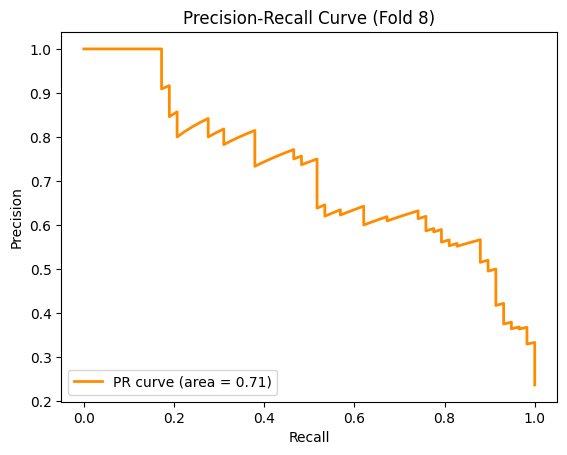

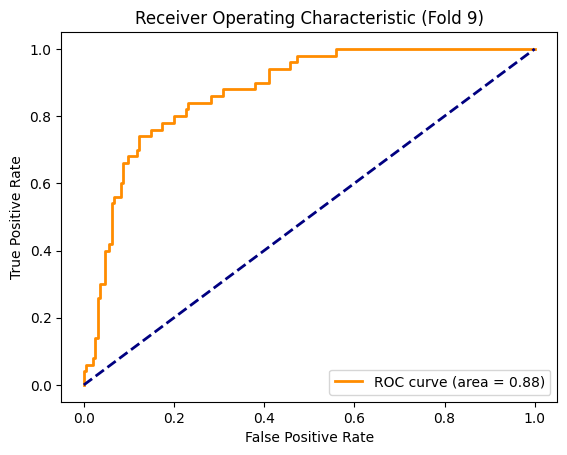

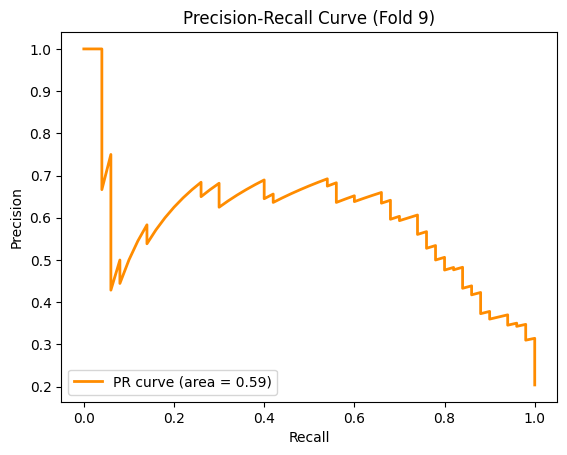

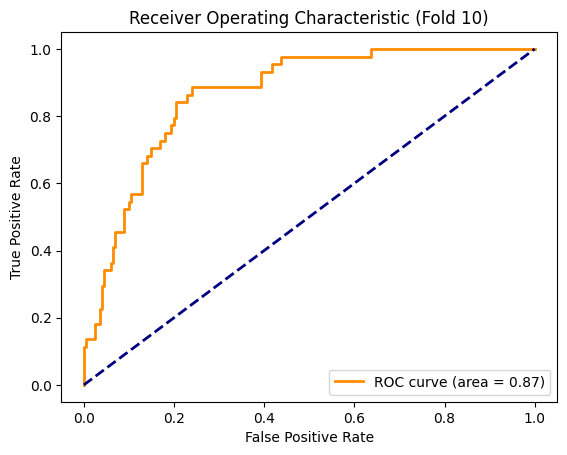

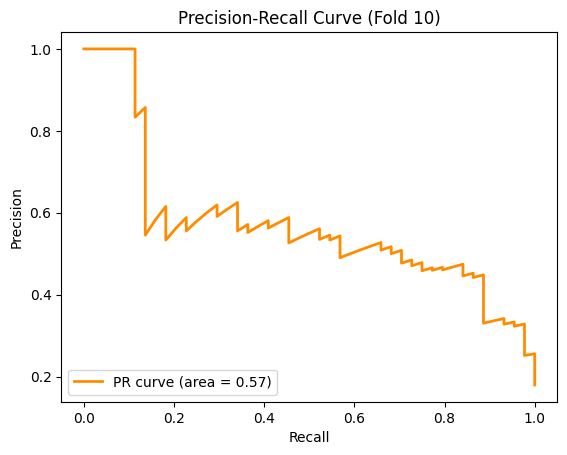

Fold 1 Results:
Accuracy: 0.7805
MCC Score: 0.2901
F1 Score: 0.3721
Recall (Sensitivity): 1.0000
Precision: 0.2408
Specificity: 0.9412
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       187
           1       0.59      0.27      0.37        59

    accuracy                           0.78       246
   macro avg       0.70      0.61      0.62       246
weighted avg       0.75      0.78      0.75       246

Confusion Matrix:
[[176  11]
 [ 43  16]]
------------------------------
Fold 2 Results:
Accuracy: 0.8252
MCC Score: 0.3674
F1 Score: 0.3582
Recall (Sensitivity): 1.0000
Precision: 0.2122
Specificity: 0.9845
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       194
           1       0.80      0.23      0.36        52

    accuracy                           0.83       246
   macro avg       0.81      0.61      0.63       246
weighted avg 

In [ ]:
#@title Train SVC on LBP Features
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    f1_score,
)
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load Data
csv_file_path = '/content/drive/MyDrive/lbp_features1.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Split Data
X = df.drop('Label', axis=1)
y = df['Label']

# Split data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize K-Fold Cross-Validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 4: Initialize SVM Model with class_weight='balanced'
svm_model = SVC(kernel='poly', degree=3, probability=True)

# Initialize lists to store performance metrics for each fold
roc_scores = []
pr_scores = []
accuracy_scores = []
classification_reports = []
confusion_matrices = []
mcc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
specificity_scores = []
sensitivity_scores = []

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Initialize an empty confusion matrix
overall_confusion_matrix = np.zeros((2, 2), dtype=int)

# K-Fold Cross-Validation
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_val)):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_val)
    y_prob = svm_model.predict_proba(X_val)[:, 1]

    # Calculate metrics for this fold
    roc_auc = roc_auc_score(y_val, y_prob)
    roc_scores.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    pr_auc = auc(recall, precision)
    pr_scores.append(pr_auc)

    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

    class_report = classification_report(y_val, y_pred)
    classification_reports.append(class_report)

    conf_matrix = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(conf_matrix)

    overall_confusion_matrix += conf_matrix

    mcc = matthews_corrcoef(y_val, y_pred)
    mcc_scores.append(mcc)

    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

    sensitivity = recall[1]
    sensitivity_scores.append(sensitivity)

    precision_ = precision[1]
    precision_scores.append(precision_)

    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    specificity_scores.append(specificity)

    # Plot ROC Curve for this fold
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold_idx+1})')
    plt.legend(loc='lower right')

    # Plot PR Curve for this fold
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Fold {fold_idx+1})')
    plt.legend(loc='lower left')
    plt.show()

# Print the results for each fold
for fold_idx in range(len(accuracy_scores)):
    print(f'Fold {fold_idx+1} Results:')
    print(f'Accuracy: {accuracy_scores[fold_idx]:.4f}')
    print(f'MCC Score: {mcc_scores[fold_idx]:.4f}')
    print(f'F1 Score: {f1_scores[fold_idx]:.4f}')
    print(f'Recall (Sensitivity): {sensitivity_scores[fold_idx]:.4f}')
    print(f'Precision: {precision_scores[fold_idx]:.4f}')
    print(f'Specificity: {specificity_scores[fold_idx]:.4f}')
    print('Classification Report:')
    print(classification_reports[fold_idx])
    print('Confusion Matrix:')
    print(confusion_matrices[fold_idx])
    print('-' * 30)

# Calculate and print mean ROC AUC and PR AUC scores, mean Accuracy
mean_roc_score = sum(roc_scores) / len(roc_scores)
mean_pr_score = sum(pr_scores) / len(pr_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_mcc = sum(mcc_scores) / len(mcc_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)
mean_recall = sum(sensitivity_scores) / len(sensitivity_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_specificity = sum(specificity_scores) / len(specificity_scores)

print(f'Mean ROC AUC Score: {mean_roc_score:.4f}')
print(f'Mean PR AUC Score: {mean_pr_score:.4f}')
print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean MCC Score: {mean_mcc:.4f}')
print(f'Mean F1 Score: {mean_f1:.4f}')
print(f'Mean Recall (Sensitivity): {mean_recall:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Specificity: {mean_specificity:.4f}')

# Print the overall confusion matrix
print("Overall Confusion Matrix:")
print(overall_confusion_matrix)

# Train the model on the entire training set (all folds combined)
svm_model.fit(X_train_val, y_train_val)

# Evaluate the model on the test set
y_test_pred = svm_model.predict(X_test)
y_test_prob = svm_model.predict_proba(X_test)[:, 1]

# Calculate metrics for the test set
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate MCC (Matthews Correlation Coefficient) Score for the test set
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Calculate F1 Score for the test set
test_f1 = f1_score(y_test, y_test_pred)

# Calculate Specificity for the test set
test_specificity = test_conf_matrix[0, 0] / (test_conf_matrix[0, 0] + test_conf_matrix[0, 1])

# Print the test set results
print('\nTest Set Results:')
print(f'Test ROC AUC Score: {test_roc_auc:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test MCC Score: {test_mcc:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Specificity: {test_specificity:.4f}')
print('Test Classification Report:')
print(test_class_report)
print('Test Confusion Matrix:')
print(test_conf_matrix)


# COMBINED LBP AND HOG FEATURES

In [ ]:
# Ensemble features
import pandas as pd
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read data from the first CSV file (64 columns)
df1 = pd.read_csv('/content/drive/MyDrive/hog_features1.csv')
print('[df1]', df1.shape)

# Read data from the second CSV file (32 columns)
df2 = pd.read_csv('/content/drive/MyDrive/lbp_features1.csv')
print('[df2]', df2.shape)

label_column = df2['Label']
df1 = df1.drop(columns=['Label'])
df2 = df2.drop(columns=['Label'])

# Combine the data from both dataframes
combined_df = pd.concat([df1, df2], axis=1, ignore_index=True)
print('[combined_df]', combined_df.shape)

# Insert the 'label' column as the last column
combined_df.insert(len(combined_df.columns), 'Label', label_column)
print('[combined_df]', combined_df.shape)

combined_df.to_csv('/content/drive/MyDrive/Ensemble_features1.csv', index=False)
print('[combined_df]', combined_df.shape)

print('features shape:', combined_df.shape)
print('Labels shape:', label_column.shape)


[df1] (3070, 1765)
[df2] (3070, 11)
[combined_df] (3070, 1774)
[combined_df] (3070, 1775)
[combined_df] (3070, 1775)
features shape: (3070, 1775)
Labels shape: (3070,)


# KFOLD ON COMBINED FEATURES

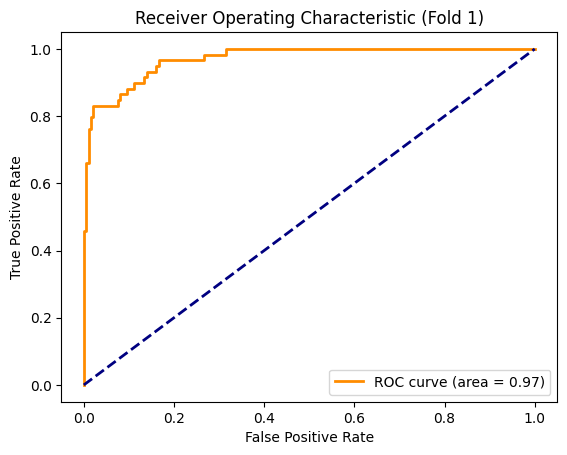

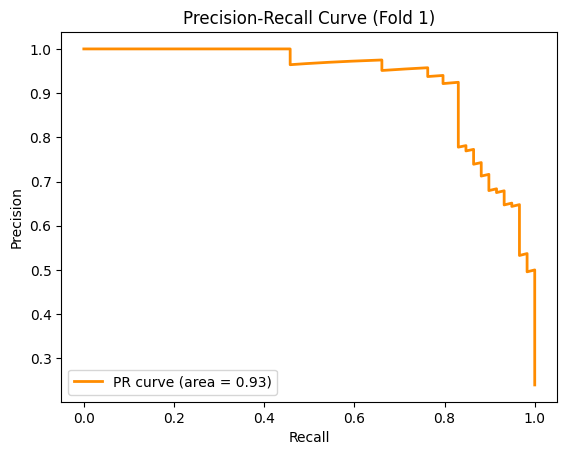

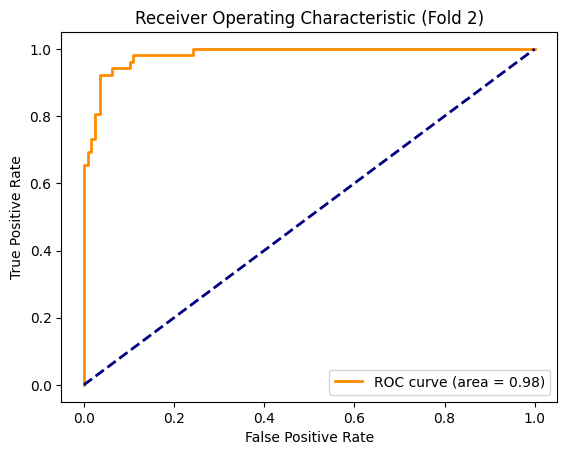

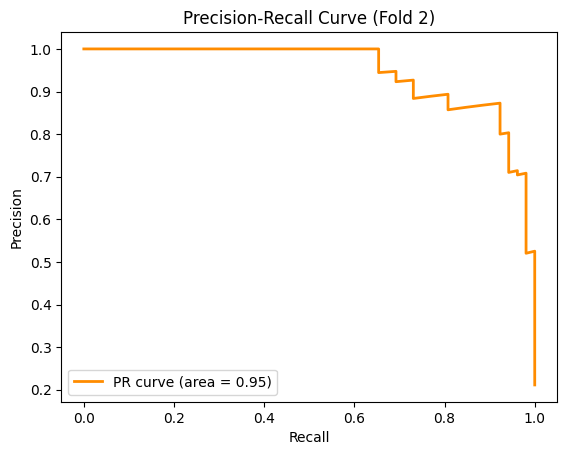

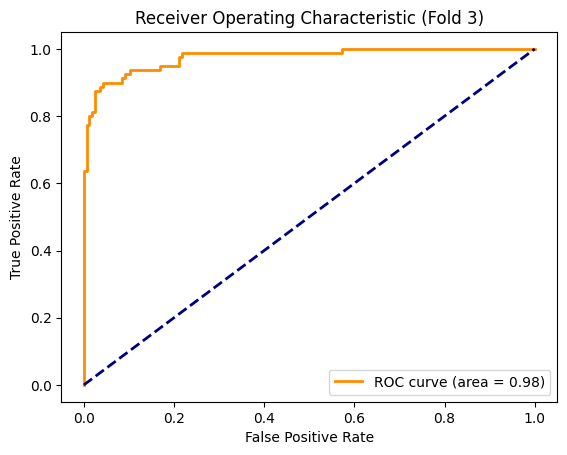

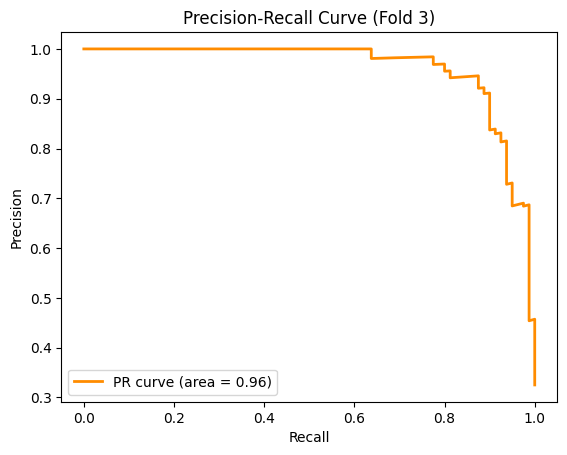

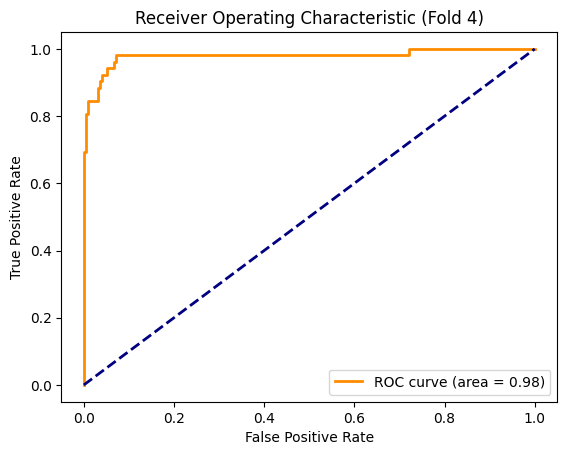

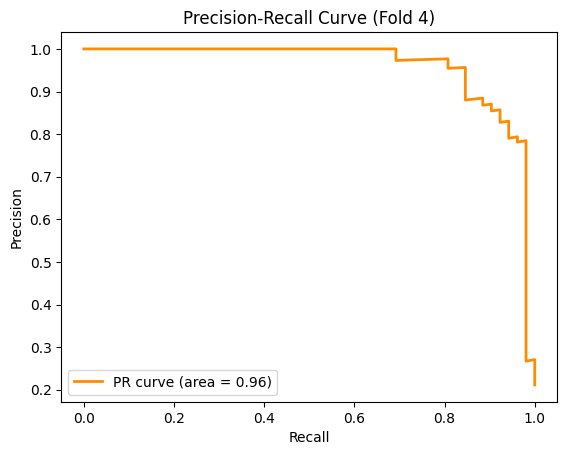

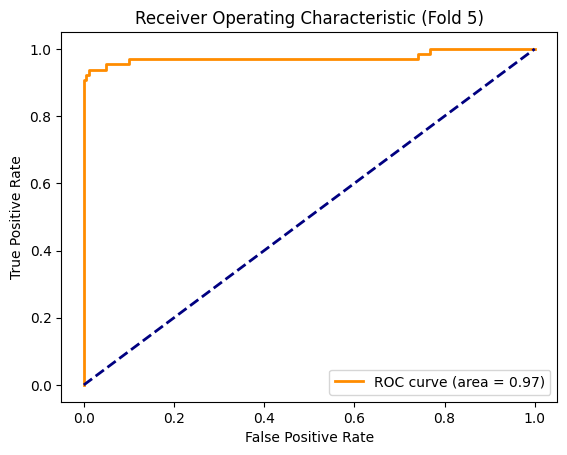

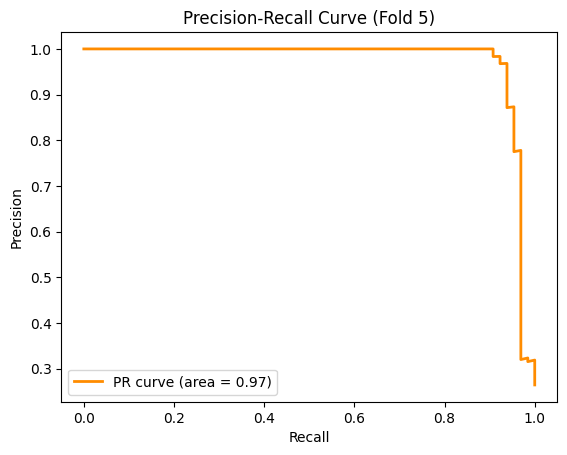

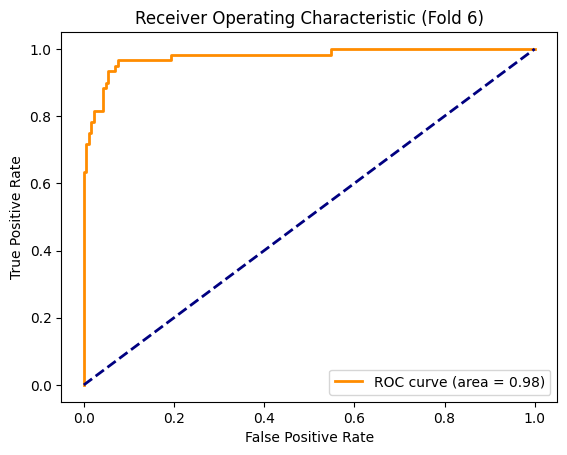

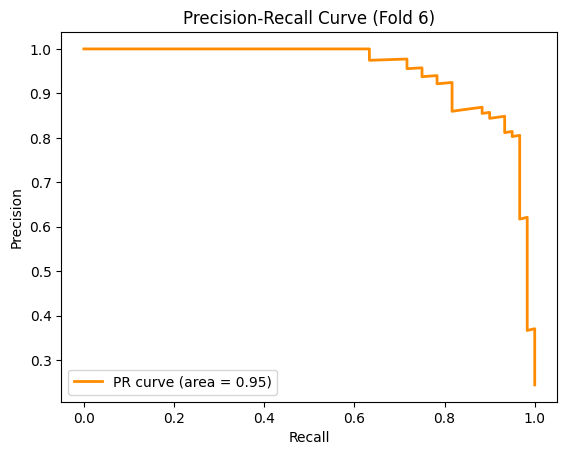

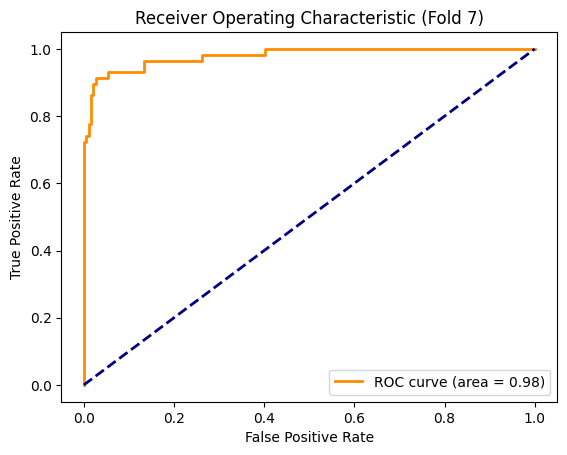

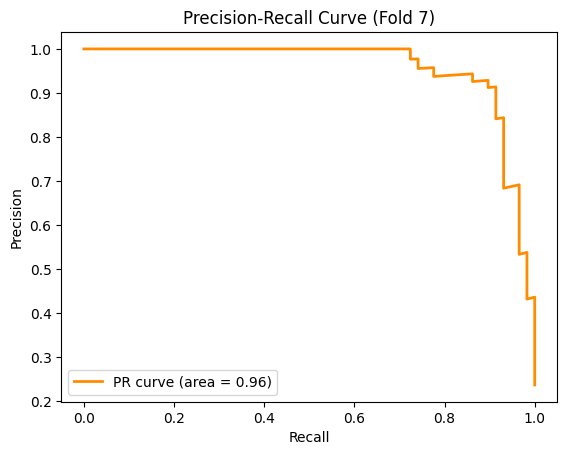

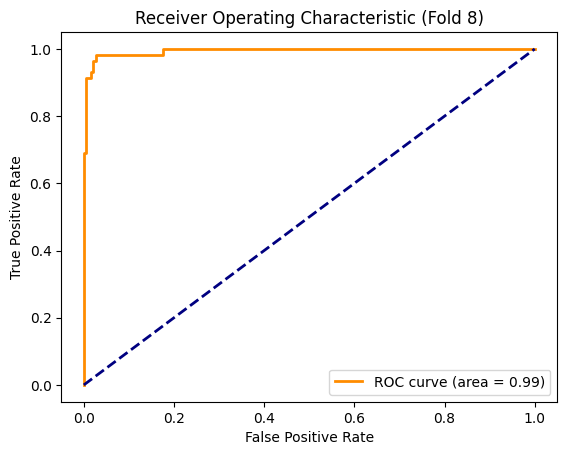

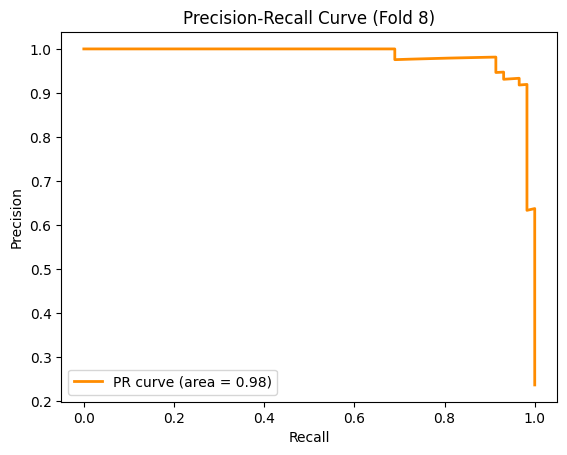

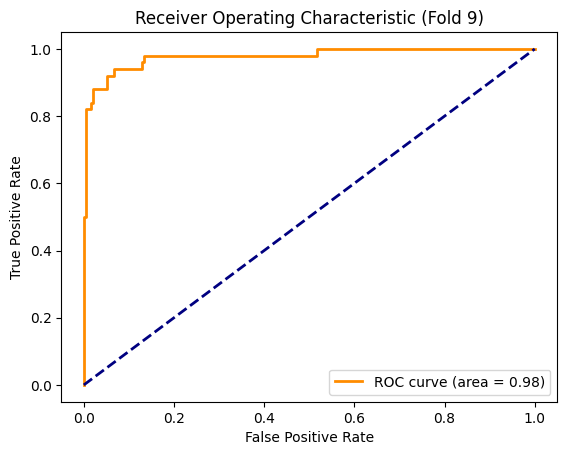

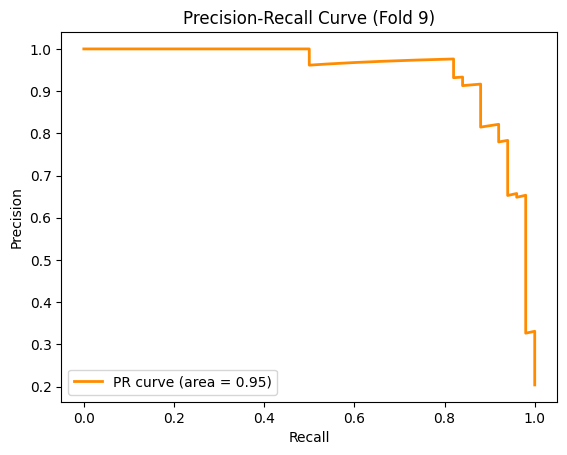

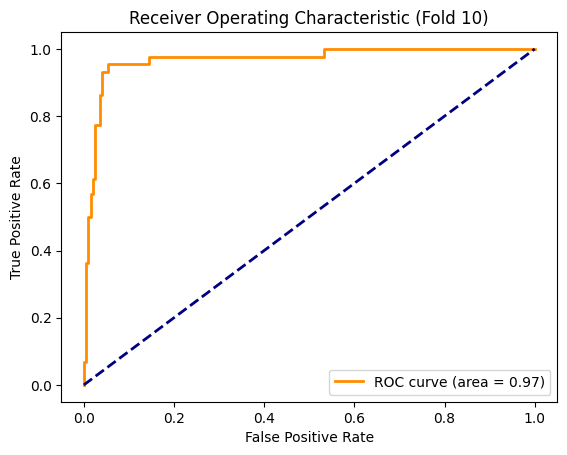

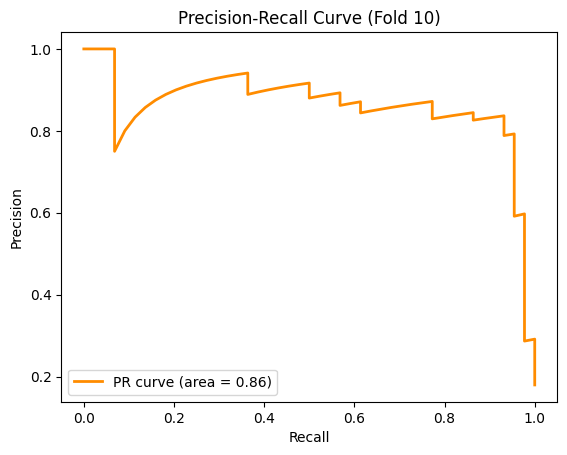

Fold 1 Results:
Accuracy: 0.9228
MCC Score: 0.7870
F1 Score: 0.8376
Recall (Sensitivity): 1.0000
Precision: 0.2408
Specificity: 0.9519
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       187
           1       0.84      0.83      0.84        59

    accuracy                           0.92       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.92      0.92      0.92       246

Confusion Matrix:
[[178   9]
 [ 10  49]]
------------------------------
Fold 2 Results:
Accuracy: 0.9553
MCC Score: 0.8692
F1 Score: 0.8972
Recall (Sensitivity): 1.0000
Precision: 0.2122
Specificity: 0.9639
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       194
           1       0.87      0.92      0.90        52

    accuracy                           0.96       246
   macro avg       0.93      0.94      0.93       246
weighted avg 

In [ ]:
#@title Train SVC on HOG + LBP Combined Features

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    f1_score,
)
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load Data
csv_file_path = '/content/drive/MyDrive/Ensemble_features1.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Split Data
X = df.drop('Label', axis=1)
y = df['Label']

# Split data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize K-Fold Cross-Validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 4: Initialize SVM Model with class_weight='balanced'
svm_model = SVC(kernel='poly', degree=3, probability=True)

# Initialize lists to store performance metrics for each fold
roc_scores = []
pr_scores = []
accuracy_scores = []
classification_reports = []
confusion_matrices = []
mcc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
specificity_scores = []
sensitivity_scores = []

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Initialize an empty confusion matrix
overall_confusion_matrix = np.zeros((2, 2), dtype=int)

# K-Fold Cross-Validation
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_val)):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_val)
    y_prob = svm_model.predict_proba(X_val)[:, 1]

    # Calculate metrics for this fold
    roc_auc = roc_auc_score(y_val, y_prob)
    roc_scores.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    pr_auc = auc(recall, precision)
    pr_scores.append(pr_auc)

    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

    class_report = classification_report(y_val, y_pred)
    classification_reports.append(class_report)

    conf_matrix = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(conf_matrix)

    overall_confusion_matrix += conf_matrix

    mcc = matthews_corrcoef(y_val, y_pred)
    mcc_scores.append(mcc)

    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

    sensitivity = recall[1]
    sensitivity_scores.append(sensitivity)

    precision_ = precision[1]
    precision_scores.append(precision_)

    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    specificity_scores.append(specificity)

    # Plot ROC Curve for this fold
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold_idx+1})')
    plt.legend(loc='lower right')

    # Plot PR Curve for this fold
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Fold {fold_idx+1})')
    plt.legend(loc='lower left')
    plt.show()

# Print the results for each fold
for fold_idx in range(len(accuracy_scores)):
    print(f'Fold {fold_idx+1} Results:')
    print(f'Accuracy: {accuracy_scores[fold_idx]:.4f}')
    print(f'MCC Score: {mcc_scores[fold_idx]:.4f}')
    print(f'F1 Score: {f1_scores[fold_idx]:.4f}')
    print(f'Recall (Sensitivity): {sensitivity_scores[fold_idx]:.4f}')
    print(f'Precision: {precision_scores[fold_idx]:.4f}')
    print(f'Specificity: {specificity_scores[fold_idx]:.4f}')
    print('Classification Report:')
    print(classification_reports[fold_idx])
    print('Confusion Matrix:')
    print(confusion_matrices[fold_idx])
    print('-' * 30)

# Calculate and print mean ROC AUC and PR AUC scores, mean Accuracy
mean_roc_score = sum(roc_scores) / len(roc_scores)
mean_pr_score = sum(pr_scores) / len(pr_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_mcc = sum(mcc_scores) / len(mcc_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)
mean_recall = sum(sensitivity_scores) / len(sensitivity_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_specificity = sum(specificity_scores) / len(specificity_scores)

print(f'Mean ROC AUC Score: {mean_roc_score:.4f}')
print(f'Mean PR AUC Score: {mean_pr_score:.4f}')
print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean MCC Score: {mean_mcc:.4f}')
print(f'Mean F1 Score: {mean_f1:.4f}')
print(f'Mean Recall (Sensitivity): {mean_recall:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Specificity: {mean_specificity:.4f}')

# Print the overall confusion matrix
print("Overall Confusion Matrix:")
print(overall_confusion_matrix)

# Train the model on the entire training set (all folds combined)
svm_model.fit(X_train_val, y_train_val)

# Evaluate the model on the test set
y_test_pred = svm_model.predict(X_test)
y_test_prob = svm_model.predict_proba(X_test)[:, 1]

# Calculate metrics for the test set
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate MCC (Matthews Correlation Coefficient) Score for the test set
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Calculate F1 Score for the test set
test_f1 = f1_score(y_test, y_test_pred)

# Calculate Specificity for the test set
test_specificity = test_conf_matrix[0, 0] / (test_conf_matrix[0, 0] + test_conf_matrix[0, 1])

# Print the test set results
print('\nTest Set Results:')
print(f'Test ROC AUC Score: {test_roc_auc:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test MCC Score: {test_mcc:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Specificity: {test_specificity:.4f}')
print('Test Classification Report:')
print(test_class_report)
print('Test Confusion Matrix:')
print(test_conf_matrix)


# FEATURE EXTRACTION THROUGH TRANSFORMER

In [ ]:
#  Correct features wala code
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import ViTModel
import csv

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = self.get_image_paths()

    def get_image_paths(self):
        image_paths = []
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Extract label from the folder name
        folder_name = os.path.basename(os.path.dirname(img_path))

        # Define a mapping from folder names to numerical labels
        label_mapping = {'Meningioma': 0, 'hybrid(G+P)': 1}

        label = label_mapping.get(folder_name, -1)  # Use -1 if the folder name is not in the mapping

        return image, label

# Set up data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Replace 'your_dataset_path' with the path to your image dataset
your_dataset_path = '/content/drive/MyDrive/brain-tumor - Copy'
custom_dataset = CustomDataset(root_dir=your_dataset_path, transform=data_transform)

# Create a data loader for the dataset
data_loader = DataLoader(custom_dataset, batch_size=1, shuffle=False)

# Instantiate the ViTModel model
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
vit_model.eval()

# Create a CSV file to store features and labels
csv_file_path = '/content/drive/MyDrive/features_with_labels11.csv'

with open(csv_file_path, 'w', newline='') as csvfile:
    # Define CSV header
    fieldnames = [f'{i}' for i in range(1, 65)] + ['Label']  # 64 feature columns and 1 label column
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Extract features and labels for each image in the dataset
    for batch, labels in data_loader:
        with torch.no_grad():
            output_features = vit_model(pixel_values=batch)

        # Output features will have the shape (batch_size, sequence_length, hidden_size)
        features = output_features.last_hidden_state[0, :64, :]  # Extracting the first 64 features

        # Calculate the mean of the features
        features_mean = torch.mean(features, dim=0)

        # Write features and label to the CSV file
        row_data = {'Label': labels.item()}
        features1 = len(features)
        for i in range(features1):
            row_data[f'{i+1}'] = features_mean[i].item()

        writer.writerow(row_data)

        # Print the shape of the extracted features
        print("Output features shape:", features_mean.shape)

print(f"Features and labels saved to {csv_file_path}")


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features shape: torch.Size([768])
Output features 

# KFOLD ON TRANSFORMER FEATURES

(3070, 65)


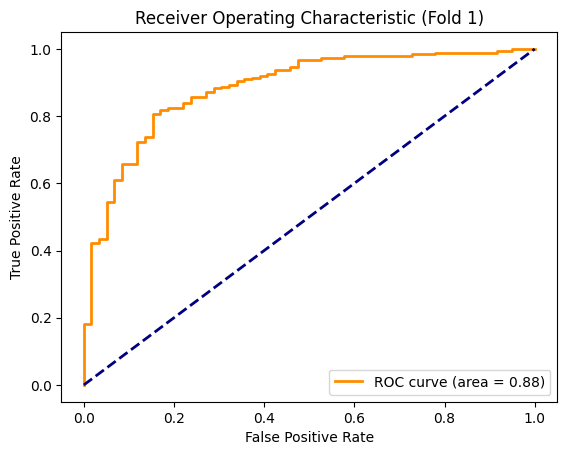

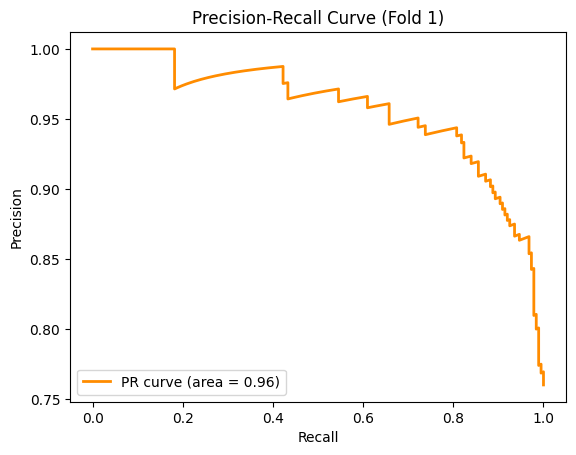

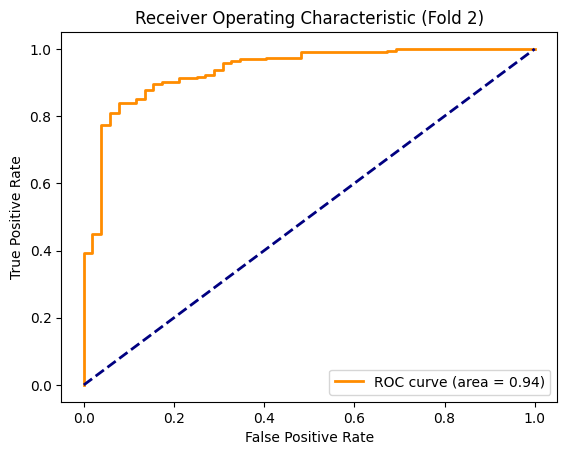

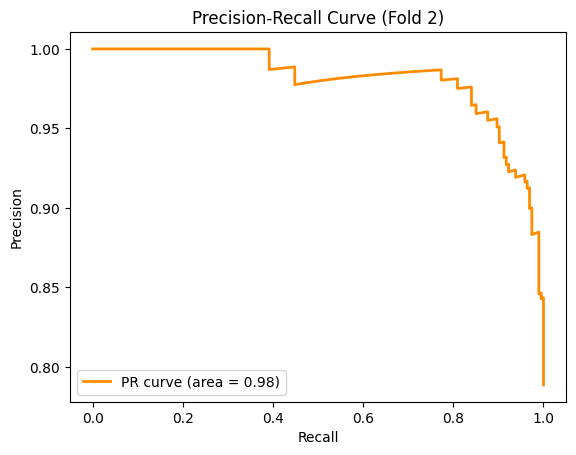

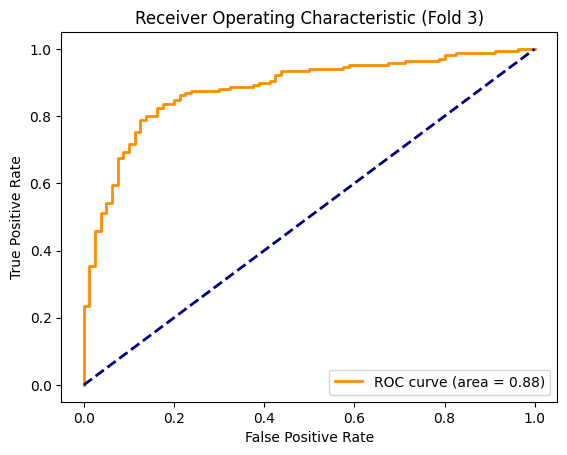

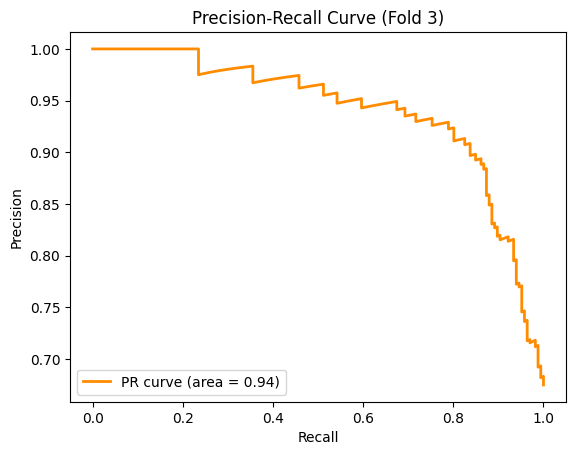

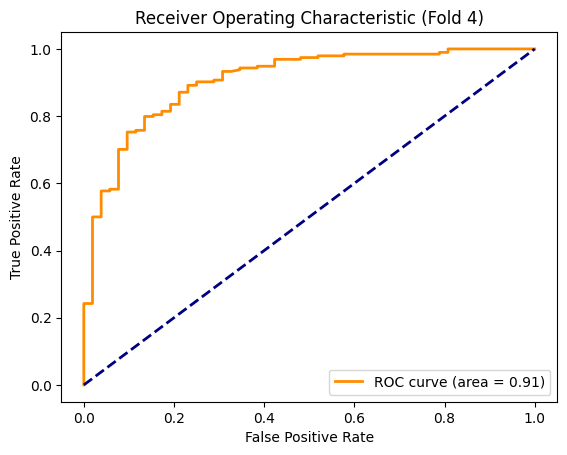

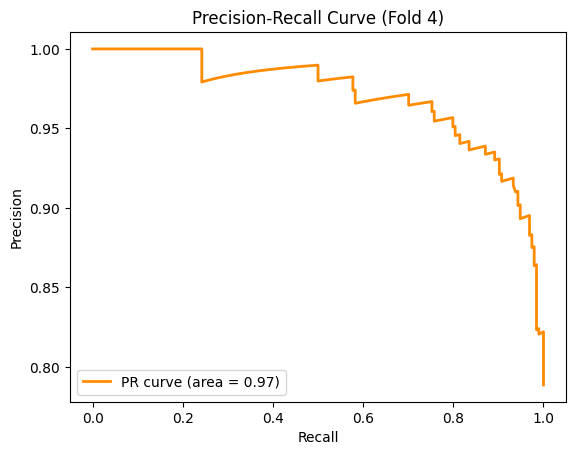

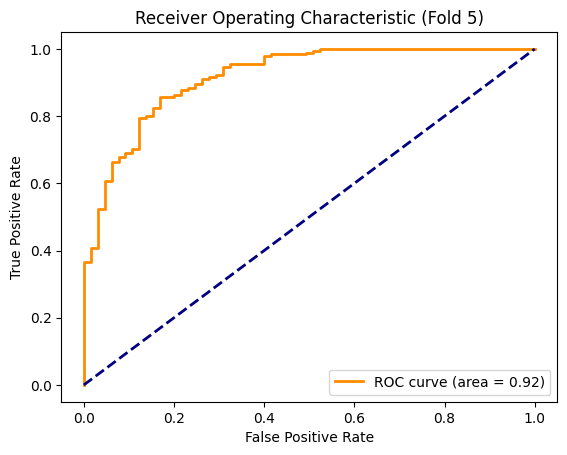

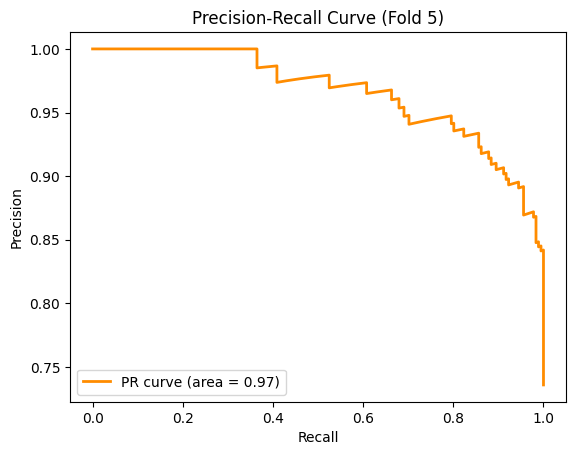

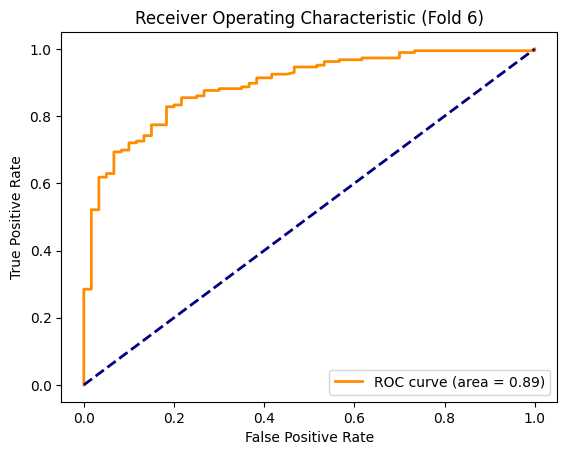

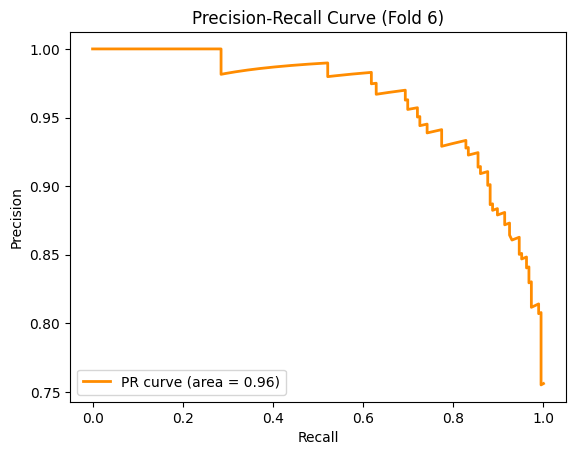

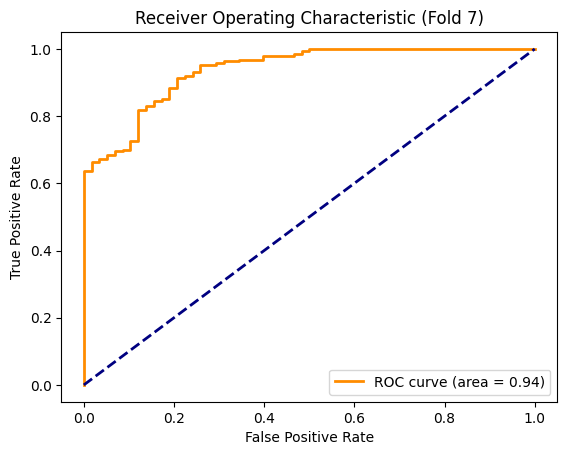

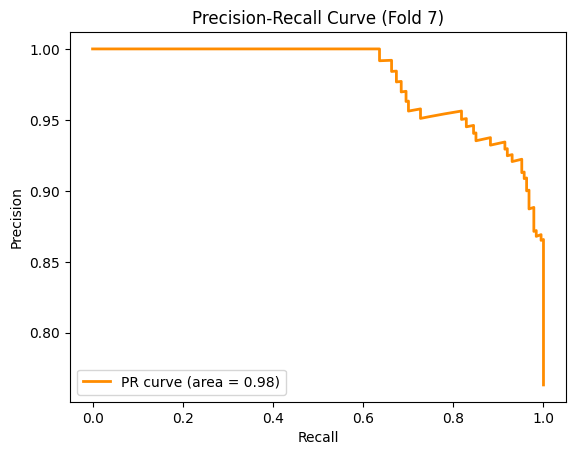

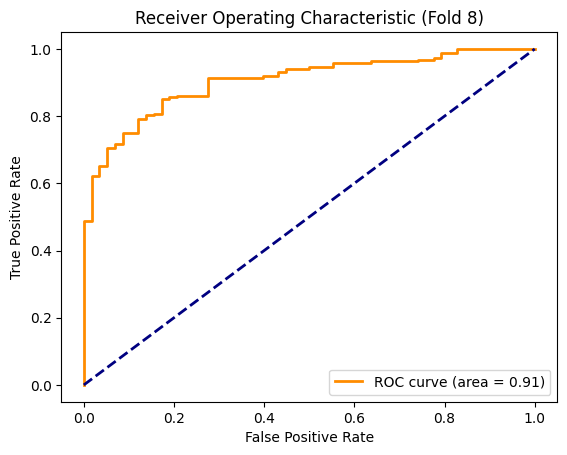

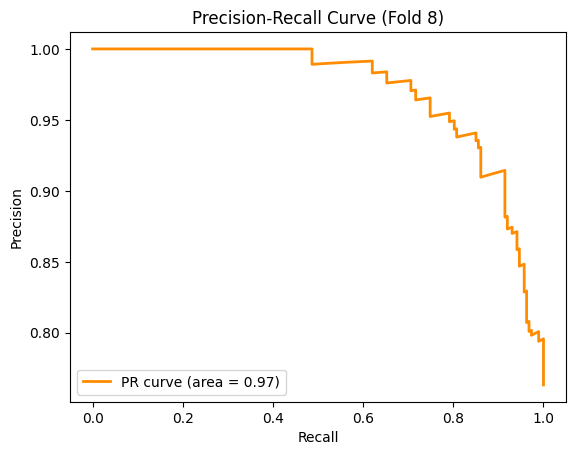

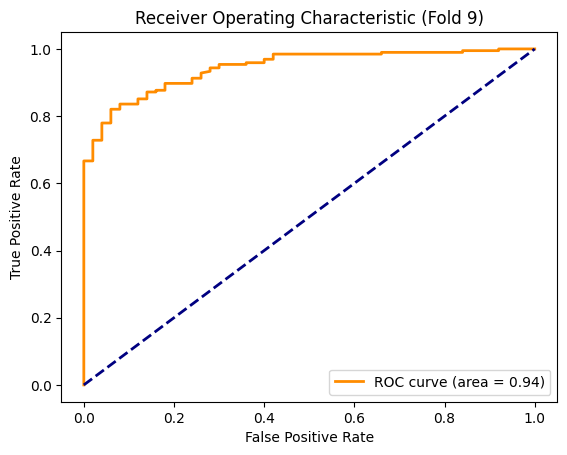

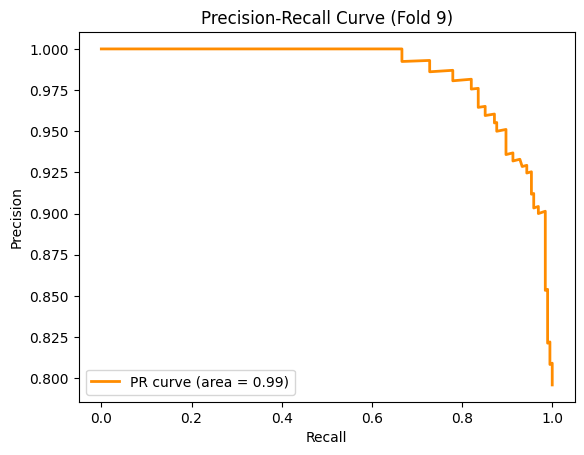

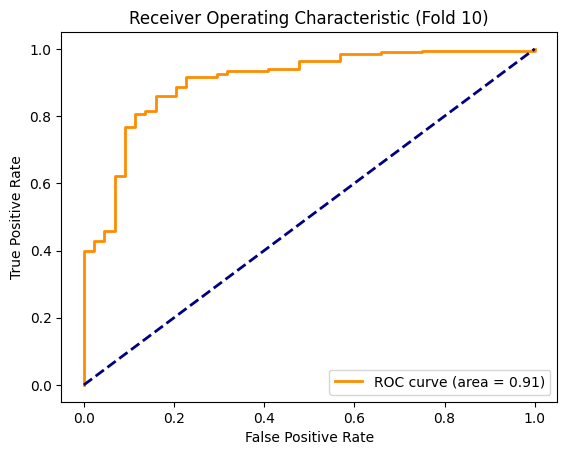

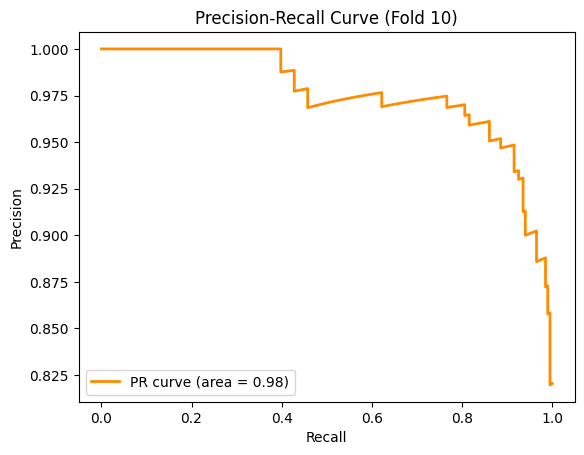

Fold 1 Results:
Accuracy: 0.8455
MCC Score: 0.5469
F1 Score: 0.9021
Recall (Sensitivity): 1.0000
Precision: 0.7633
Specificity: 0.5593
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63        59
           1       0.87      0.94      0.90       187

    accuracy                           0.85       246
   macro avg       0.80      0.75      0.77       246
weighted avg       0.84      0.85      0.84       246

Confusion Matrix:
[[ 33  26]
 [ 12 175]]
------------------------------
Fold 2 Results:
Accuracy: 0.8984
MCC Score: 0.6768
F1 Score: 0.9373
Recall (Sensitivity): 1.0000
Precision: 0.7918
Specificity: 0.6538
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        52
           1       0.91      0.96      0.94       194

    accuracy                           0.90       246
   macro avg       0.87      0.81      0.83       246
weighted avg 

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    f1_score,
)
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load Data
csv_file_path = '/content/drive/MyDrive/features_with_labels11.csv'
df = pd.read_csv(csv_file_path)
print(df.shape)

# Step 2: Split Data
X = df.drop('Label', axis=1)
y = df['Label']

# Split data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize K-Fold Cross-Validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 4: Initialize SVM Model with class_weight='balanced'
svm_model = SVC(kernel='poly', degree=3, probability=True)

# Initialize lists to store performance metrics for each fold
roc_scores = []
pr_scores = []
accuracy_scores = []
classification_reports = []
confusion_matrices = []
mcc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
specificity_scores = []
sensitivity_scores = []

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Initialize an empty confusion matrix
overall_confusion_matrix = np.zeros((2, 2), dtype=int)

# K-Fold Cross-Validation
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_val)):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_val)
    y_prob = svm_model.predict_proba(X_val)[:, 1]

    # Calculate metrics for this fold
    roc_auc = roc_auc_score(y_val, y_prob)
    roc_scores.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    pr_auc = auc(recall, precision)
    pr_scores.append(pr_auc)

    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

    class_report = classification_report(y_val, y_pred)
    classification_reports.append(class_report)

    conf_matrix = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(conf_matrix)

    overall_confusion_matrix += conf_matrix

    mcc = matthews_corrcoef(y_val, y_pred)
    mcc_scores.append(mcc)

    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

    sensitivity = recall[1]
    sensitivity_scores.append(sensitivity)

    precision_ = precision[1]
    precision_scores.append(precision_)

    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    specificity_scores.append(specificity)

    # Plot ROC Curve for this fold
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold_idx+1})')
    plt.legend(loc='lower right')

    # Plot PR Curve for this fold
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Fold {fold_idx+1})')
    plt.legend(loc='lower left')
    plt.show()

# Print the results for each fold
for fold_idx in range(len(accuracy_scores)):
    print(f'Fold {fold_idx+1} Results:')
    print(f'Accuracy: {accuracy_scores[fold_idx]:.4f}')
    print(f'MCC Score: {mcc_scores[fold_idx]:.4f}')
    print(f'F1 Score: {f1_scores[fold_idx]:.4f}')
    print(f'Recall (Sensitivity): {sensitivity_scores[fold_idx]:.4f}')
    print(f'Precision: {precision_scores[fold_idx]:.4f}')
    print(f'Specificity: {specificity_scores[fold_idx]:.4f}')
    print('Classification Report:')
    print(classification_reports[fold_idx])
    print('Confusion Matrix:')
    print(confusion_matrices[fold_idx])
    print('-' * 30)

# Calculate and print mean ROC AUC and PR AUC scores, mean Accuracy
mean_roc_score = sum(roc_scores) / len(roc_scores)
mean_pr_score = sum(pr_scores) / len(pr_scores)
mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
mean_mcc = sum(mcc_scores) / len(mcc_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)
mean_recall = sum(sensitivity_scores) / len(sensitivity_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_specificity = sum(specificity_scores) / len(specificity_scores)

print(f'Mean ROC AUC Score: {mean_roc_score:.4f}')
print(f'Mean PR AUC Score: {mean_pr_score:.4f}')
print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean MCC Score: {mean_mcc:.4f}')
print(f'Mean F1 Score: {mean_f1:.4f}')
print(f'Mean Recall (Sensitivity): {mean_recall:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Specificity: {mean_specificity:.4f}')

# Print the overall confusion matrix
print("Overall Confusion Matrix:")
print(overall_confusion_matrix)

# Train the model on the entire training set (all folds combined)
svm_model.fit(X_train_val, y_train_val)

# Evaluate the model on the test set
y_test_pred = svm_model.predict(X_test)
y_test_prob = svm_model.predict_proba(X_test)[:, 1]

# Calculate metrics for the test set
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate MCC (Matthews Correlation Coefficient) Score for the test set
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Calculate F1 Score for the test set
test_f1 = f1_score(y_test, y_test_pred)

# Calculate Specificity for the test set
test_specificity = test_conf_matrix[0, 0] / (test_conf_matrix[0, 0] + test_conf_matrix[0, 1])

# Print the test set results
print('\nTest Set Results:')
print(f'Test ROC AUC Score: {test_roc_auc:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test MCC Score: {test_mcc:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Specificity: {test_specificity:.4f}')
print('Test Classification Report:')
print(test_class_report)
print('Test Confusion Matrix:')
print(test_conf_matrix)


# COMBINED TRANSFORMER FEATURES + HOG FEATURES + LBP FEATURES

In [ ]:
#@title ENSEMBLE BOTH TRANSFORMER FEATURES AND HOG AND LBP

#Ensemble features
import pandas as pd
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read data from the three CSV feature files
df1 = pd.read_csv('/content/drive/MyDrive/lbp_features1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/hog_features1.csv')
df3 = pd.read_csv('/content/drive/MyDrive/features_with_labels11.csv')
label_column = df3['Label']
df1 = df1.drop(columns=['Label'])
df2 = df2.drop(columns=['Label'])
df3 = df3.drop(columns=['Label'])

# Combine the data from both dataframes
combined_df = pd.concat([df1, df2, df3], axis=1, ignore_index=True)

# Insert the 'label' column as the last column
combined_df.insert(len(combined_df.columns), 'Label', label_column)

combined_df.to_csv('Ensemble_features_12.csv', index=False)


In [ ]:
print(combined_df.shape)

(3070, 1839)


# MLP ON ALL COMBINED FEATURES

Epoch 1/10
70/70 [==============================] - 4s 8ms/step - loss: 0.4666 - accuracy: 0.7905 - val_loss: 0.4241 - val_accuracy: 0.7886
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 0.3306 - accuracy: 0.8484 - val_loss: 0.3139 - val_accuracy: 0.8618
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 0.2872 - accuracy: 0.8769 - val_loss: 0.3693 - val_accuracy: 0.8415
Epoch 4/10
70/70 [==============================] - 0s 4ms/step - loss: 0.2695 - accuracy: 0.8873 - val_loss: 0.2879 - val_accuracy: 0.8821
Epoch 5/10
70/70 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.9149 - val_loss: 0.2568 - val_accuracy: 0.8902
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 0.2406 - accuracy: 0.8964 - val_loss: 0.2580 - val_accuracy: 0.9024
Epoch 7/10
70/70 [==============================] - 0s 4ms/step - loss: 0.1804 - accuracy: 0.9303 - val_loss: 0.2557 - val_accuracy: 0.8902
Epoch 8/10
70/70 [==

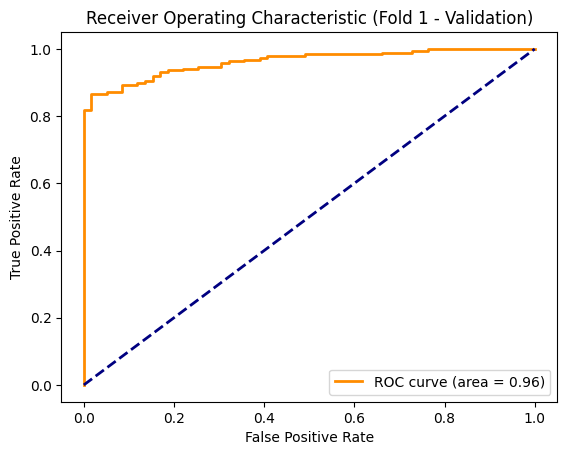

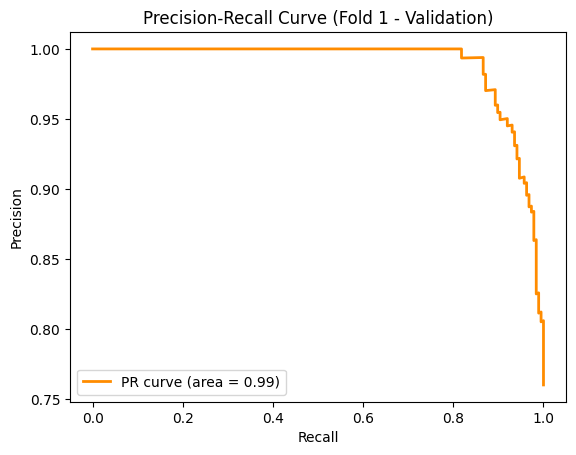

Epoch 1/10
70/70 [==============================] - 0s 5ms/step - loss: 0.1245 - accuracy: 0.9475 - val_loss: 0.1212 - val_accuracy: 0.9553
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 0.1557 - accuracy: 0.9344 - val_loss: 0.2527 - val_accuracy: 0.8618
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 0.1241 - accuracy: 0.9507 - val_loss: 0.1562 - val_accuracy: 0.9309
Epoch 4/10
70/70 [==============================] - 0s 7ms/step - loss: 0.0928 - accuracy: 0.9652 - val_loss: 0.0973 - val_accuracy: 0.9553
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0815 - accuracy: 0.9701 - val_loss: 0.1089 - val_accuracy: 0.9634
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.9738 - val_loss: 0.1014 - val_accuracy: 0.9675
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0685 - accuracy: 0.9738 - val_loss: 0.3939 - val_accuracy: 0.8618
Epoch 8/10
70/70 [==

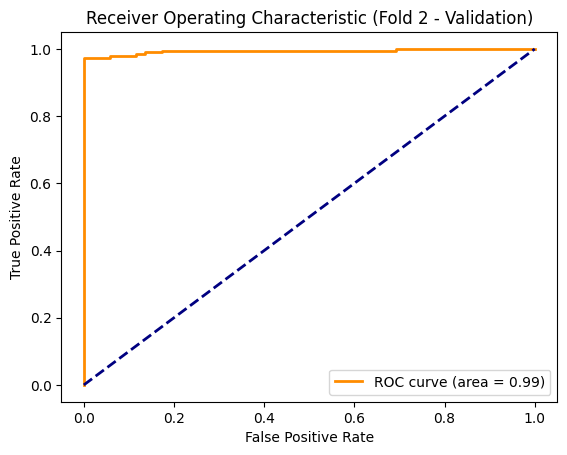

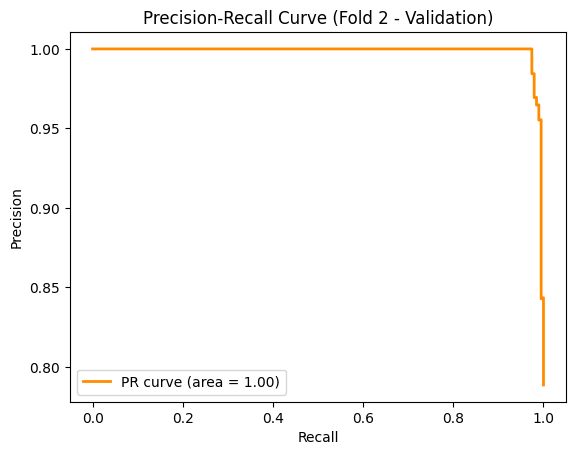

Epoch 1/10
70/70 [==============================] - 1s 8ms/step - loss: 0.0894 - accuracy: 0.9638 - val_loss: 0.0458 - val_accuracy: 0.9919
Epoch 2/10
70/70 [==============================] - 1s 7ms/step - loss: 0.0345 - accuracy: 0.9891 - val_loss: 0.0340 - val_accuracy: 0.9919
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 0.0395 - val_accuracy: 0.9837
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0803 - accuracy: 0.9679 - val_loss: 0.0760 - val_accuracy: 0.9756
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0316 - accuracy: 0.9896 - val_loss: 0.0998 - val_accuracy: 0.9634
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.1190 - val_accuracy: 0.9431
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.0580 - val_accuracy: 0.9756
Epoch 8/10
70/70 [==

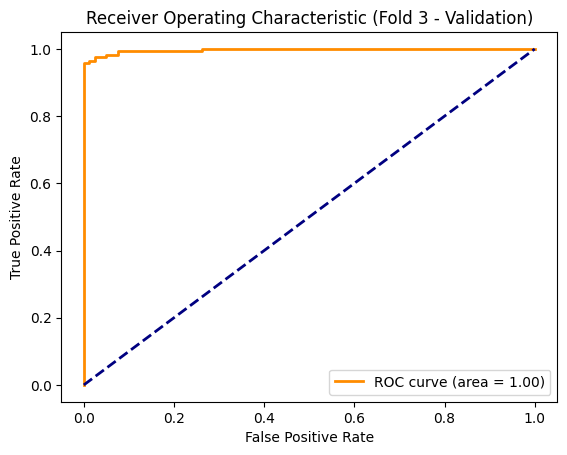

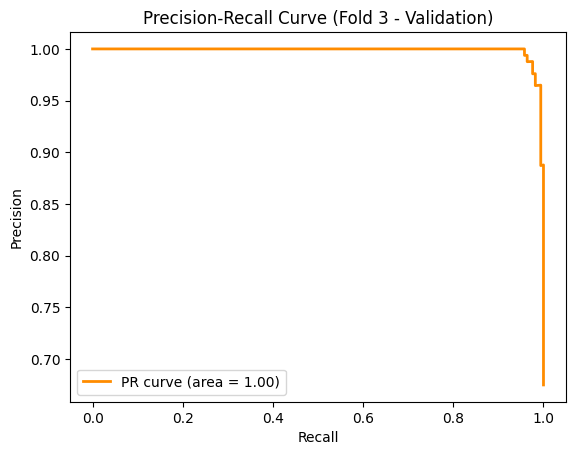

Epoch 1/10
70/70 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0310 - val_accuracy: 0.9837
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.1695 - val_accuracy: 0.9309
Epoch 3/10
70/70 [==============================] - 0s 4ms/step - loss: 0.0416 - accuracy: 0.9855 - val_loss: 0.0169 - val_accuracy: 0.9959
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 0.1172 - accuracy: 0.9557 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 8/10
70/70 [==

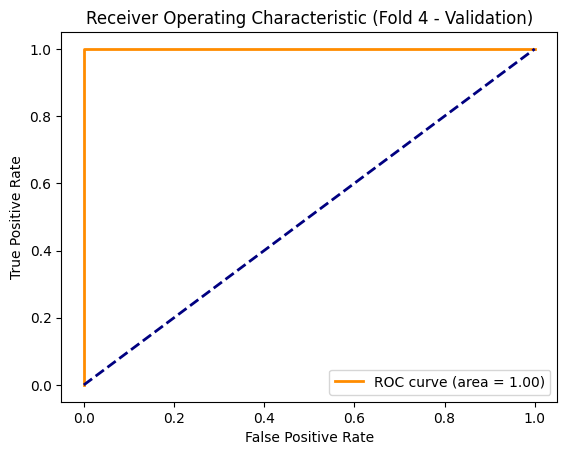

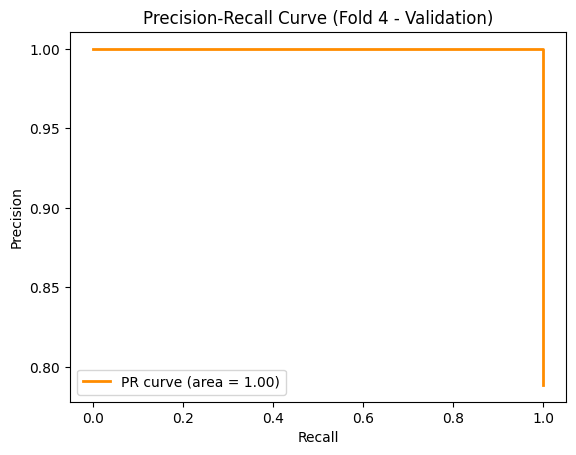

Epoch 1/10
70/70 [==============================] - 0s 5ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 4.8825e-04 - val_accuracy: 1.0000
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 5.2212e-04 - accuracy: 1.0000 - val_loss: 3.4920e-04 - val_accuracy: 1.0000
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 3.9400e-04 - accuracy: 1.0000 - val_loss: 3.6093e-04 - val_accuracy: 1.0000
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 3.4169e-04 - accuracy: 1.0000 - val_loss: 3.1714e-04 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 2.7595e-04 - accuracy: 1.0000 - val_loss: 3.0038e-04 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 2.4604e-04 - accuracy: 1.0000 - val_loss: 2.4400e-04 - val_accuracy: 1.0000
Epoch 7/10
70/70 [==============================] - 0s 7ms/step - loss: 2.1399e-04 - accuracy: 1.0000 - val_loss: 2.

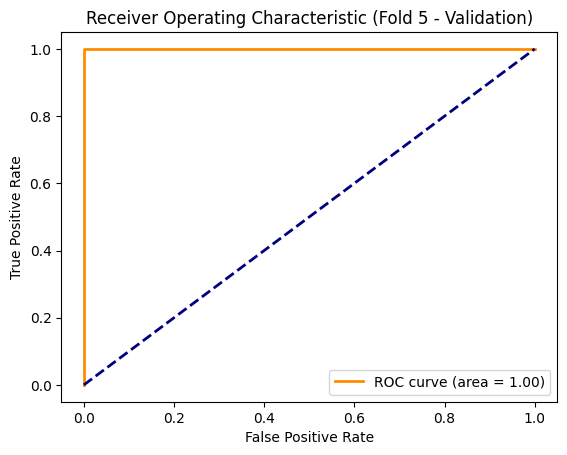

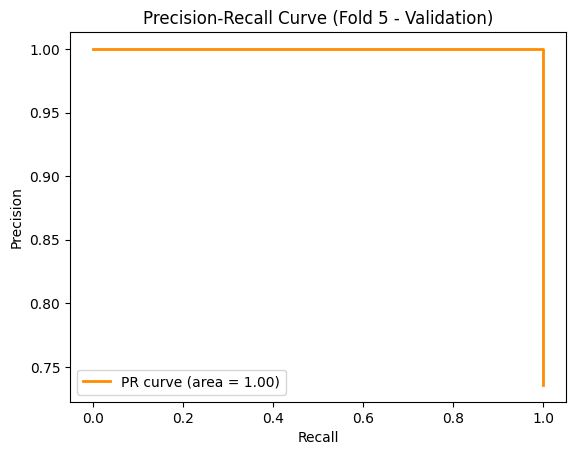

Epoch 1/10
70/70 [==============================] - 1s 8ms/step - loss: 1.4260e-04 - accuracy: 1.0000 - val_loss: 1.2649e-04 - val_accuracy: 1.0000
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 1.2379e-04 - accuracy: 1.0000 - val_loss: 1.2845e-04 - val_accuracy: 1.0000
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 1.1265e-04 - accuracy: 1.0000 - val_loss: 1.1393e-04 - val_accuracy: 1.0000
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 9.9061e-05 - accuracy: 1.0000 - val_loss: 1.1128e-04 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 9.3021e-05 - accuracy: 1.0000 - val_loss: 1.0566e-04 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 8.5682e-05 - accuracy: 1.0000 - val_loss: 9.8527e-05 - val_accuracy: 1.0000
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 7.6952e-05 - accuracy: 1.0000 - val_loss

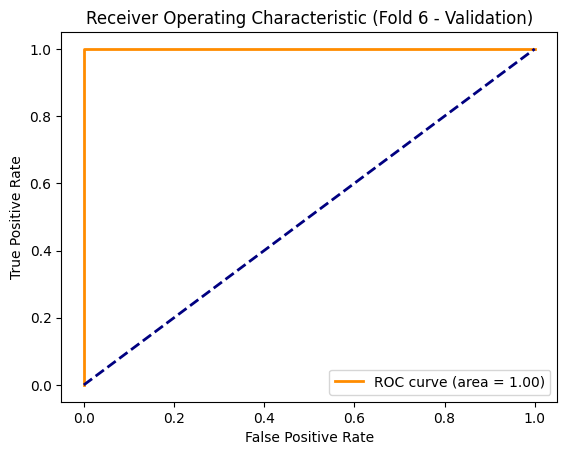

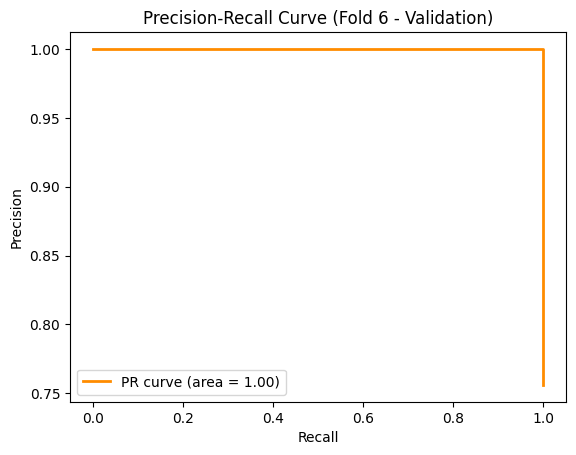

Epoch 1/10
70/70 [==============================] - 0s 6ms/step - loss: 6.0861e-05 - accuracy: 1.0000 - val_loss: 1.4213e-05 - val_accuracy: 1.0000
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 5.6902e-05 - accuracy: 1.0000 - val_loss: 1.5932e-05 - val_accuracy: 1.0000
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 5.1450e-05 - accuracy: 1.0000 - val_loss: 1.3521e-05 - val_accuracy: 1.0000
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 4.7183e-05 - accuracy: 1.0000 - val_loss: 1.2569e-05 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 4.3286e-05 - accuracy: 1.0000 - val_loss: 1.2174e-05 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 4.0293e-05 - accuracy: 1.0000 - val_loss: 1.3193e-05 - val_accuracy: 1.0000
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 3.6977e-05 - accuracy: 1.0000 - val_loss

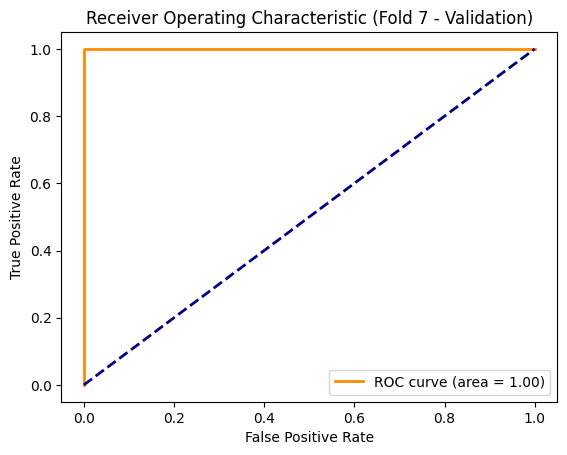

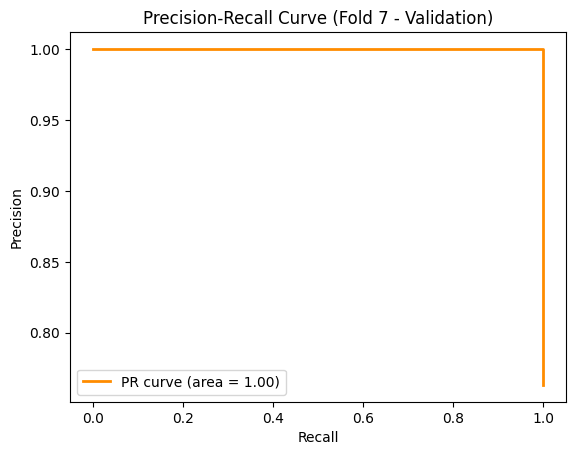

Epoch 1/10
70/70 [==============================] - 1s 8ms/step - loss: 2.7645e-05 - accuracy: 1.0000 - val_loss: 1.4250e-05 - val_accuracy: 1.0000
Epoch 2/10
70/70 [==============================] - 0s 7ms/step - loss: 2.5293e-05 - accuracy: 1.0000 - val_loss: 1.3119e-05 - val_accuracy: 1.0000
Epoch 3/10
70/70 [==============================] - 1s 7ms/step - loss: 2.3469e-05 - accuracy: 1.0000 - val_loss: 1.2162e-05 - val_accuracy: 1.0000
Epoch 4/10
70/70 [==============================] - 1s 7ms/step - loss: 2.2566e-05 - accuracy: 1.0000 - val_loss: 1.1072e-05 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 1s 8ms/step - loss: 2.0913e-05 - accuracy: 1.0000 - val_loss: 1.1607e-05 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 1s 8ms/step - loss: 1.9000e-05 - accuracy: 1.0000 - val_loss: 1.1077e-05 - val_accuracy: 1.0000
Epoch 7/10
70/70 [==============================] - 0s 7ms/step - loss: 1.7870e-05 - accuracy: 1.0000 - val_loss

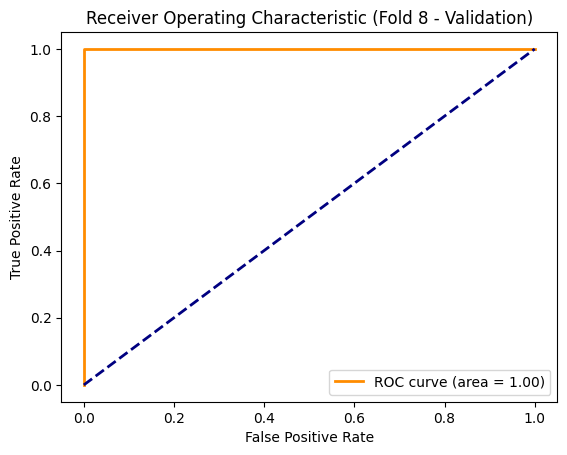

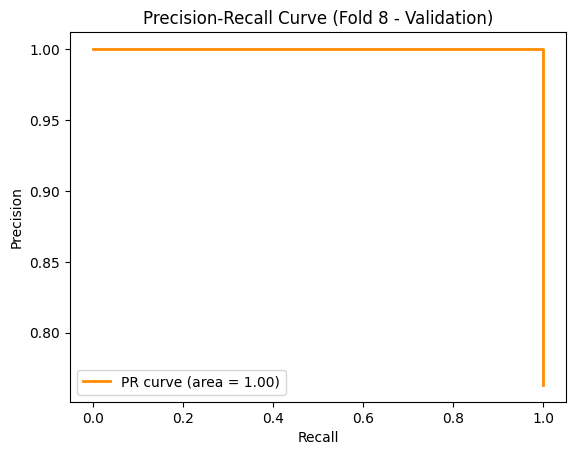

Epoch 1/10
70/70 [==============================] - 0s 6ms/step - loss: 1.3464e-05 - accuracy: 1.0000 - val_loss: 1.2833e-05 - val_accuracy: 1.0000
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 1.2426e-05 - accuracy: 1.0000 - val_loss: 1.3326e-05 - val_accuracy: 1.0000
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 1.1775e-05 - accuracy: 1.0000 - val_loss: 1.3581e-05 - val_accuracy: 1.0000
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 1.1024e-05 - accuracy: 1.0000 - val_loss: 1.2988e-05 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 1.0299e-05 - accuracy: 1.0000 - val_loss: 1.2476e-05 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 9.7621e-06 - accuracy: 1.0000 - val_loss: 1.1555e-05 - val_accuracy: 1.0000
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 9.3308e-06 - accuracy: 1.0000 - val_loss

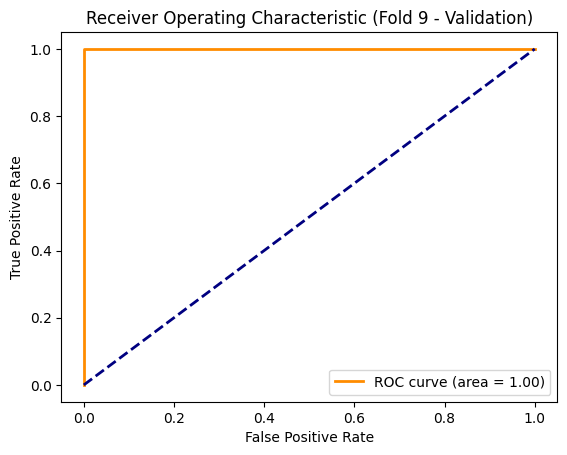

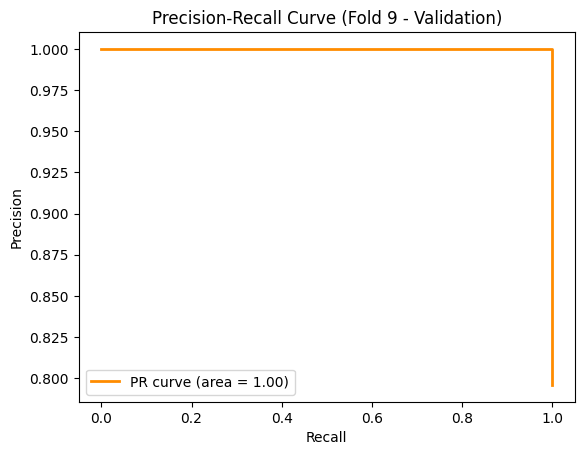

Epoch 1/10
70/70 [==============================] - 0s 6ms/step - loss: 7.7499e-06 - accuracy: 1.0000 - val_loss: 7.1671e-06 - val_accuracy: 1.0000
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 7.2224e-06 - accuracy: 1.0000 - val_loss: 6.8869e-06 - val_accuracy: 1.0000
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 6.9071e-06 - accuracy: 1.0000 - val_loss: 6.8027e-06 - val_accuracy: 1.0000
Epoch 4/10
70/70 [==============================] - 0s 5ms/step - loss: 6.5224e-06 - accuracy: 1.0000 - val_loss: 6.4874e-06 - val_accuracy: 1.0000
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 6.0598e-06 - accuracy: 1.0000 - val_loss: 6.1683e-06 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 0s 5ms/step - loss: 5.7583e-06 - accuracy: 1.0000 - val_loss: 6.0306e-06 - val_accuracy: 1.0000
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 5.3963e-06 - accuracy: 1.0000 - val_loss

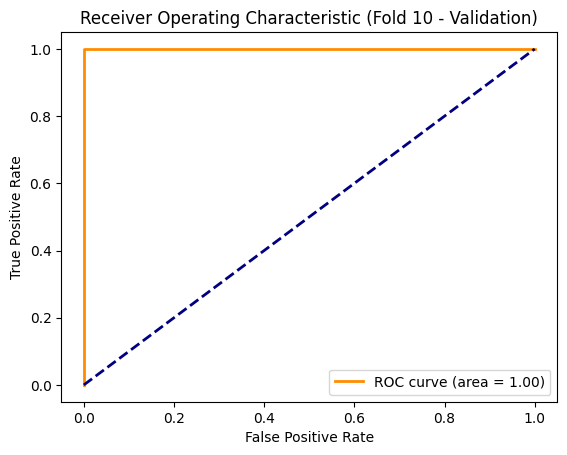

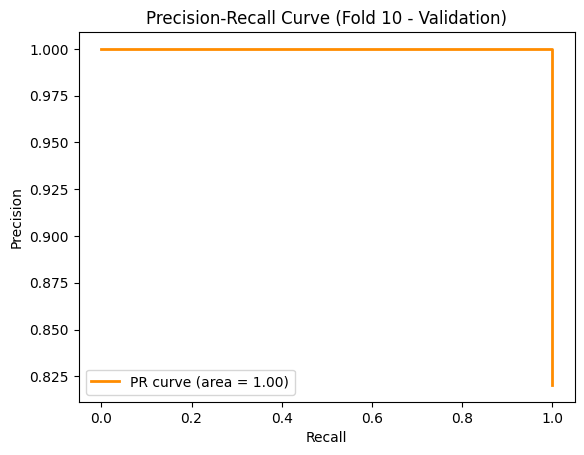

Training Fold 1 Results:
Accuracy: 0.8862
MCC Score: 0.6756
F1 Score: 0.9267
Recall (Sensitivity): 1.0000
Precision: 0.7633
Specificity: 0.6949
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.75        59
           1       0.91      0.95      0.93       187

    accuracy                           0.89       246
   macro avg       0.86      0.82      0.84       246
weighted avg       0.88      0.89      0.88       246

Confusion Matrix:
[[ 41  18]
 [ 10 177]]
------------------------------
Training Fold 2 Results:
Accuracy: 0.9228
MCC Score: 0.8128
F1 Score: 0.9485
Recall (Sensitivity): 1.0000
Precision: 0.7918
Specificity: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        52
           1       1.00      0.90      0.95       194

    accuracy                           0.92       246
   macro avg       0.87      0.95      0.90      

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, f1_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load Data
csv_file_path = '/content/Ensemble_features_12.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Split Data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Label', axis=1), df['Label'], test_size=0.2, random_state=42)

# Step 3: Initialize K-Fold Cross-Validator for the training set
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 4: Initialize MLP Model
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Initialize lists to store performance metrics for each fold
roc_scores = []
pr_scores = []
accuracy_scores = []
classification_reports = []
confusion_matrices = []
mcc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
specificity_scores = []

# Training Loop
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Convert labels to one-hot encoding for categorical crossentropy
    y_fold_train_onehot = tf.keras.utils.to_categorical(y_fold_train, num_classes=2)
    y_fold_val_onehot = tf.keras.utils.to_categorical(y_fold_val, num_classes=2)

    # Train the MLP model
    mlp_model.fit(X_fold_train, y_fold_train_onehot, epochs=10, batch_size=32, validation_data=(X_fold_val, y_fold_val_onehot))

    # Predictions on the validation set
    y_prob_val = mlp_model.predict(X_fold_val)[:, 1]
    y_pred_val = np.argmax(mlp_model.predict(X_fold_val), axis=1)

    # Calculate metrics for this fold on the validation set
    roc_auc_val = roc_auc_score(y_fold_val, y_prob_val)
    roc_scores.append(roc_auc_val)

    precision_val, recall_val, _ = precision_recall_curve(y_fold_val, y_prob_val)
    pr_auc_val = auc(recall_val, precision_val)
    pr_scores.append(pr_auc_val)

    accuracy_val = accuracy_score(y_fold_val, y_pred_val)
    accuracy_scores.append(accuracy_val)

    class_report_val = classification_report(y_fold_val, y_pred_val)
    classification_reports.append(class_report_val)

    conf_matrix_val = confusion_matrix(y_fold_val, y_pred_val)
    confusion_matrices.append(conf_matrix_val)

    mcc_val = matthews_corrcoef(y_fold_val, y_pred_val)
    mcc_scores.append(mcc_val)

    f1_val = f1_score(y_fold_val, y_pred_val)
    f1_scores.append(f1_val)

    sensitivity_val = recall_val[1]
    recall_scores.append(sensitivity_val)

    precision_val_ = precision_val[1]
    precision_scores.append(precision_val_)

    specificity_val = conf_matrix_val[0, 0] / (conf_matrix_val[0, 0] + conf_matrix_val[0, 1])
    specificity_scores.append(specificity_val)

    # Plot ROC Curve for this fold on the validation set
    fpr_val, tpr_val, _ = roc_curve(y_fold_val, y_prob_val)
    plt.figure()
    plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold_idx+1} - Validation)')
    plt.legend(loc='lower right')

    # Plot PR Curve for this fold on the validation set
    plt.figure()
    plt.plot(recall_val, precision_val, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc_val:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (Fold {fold_idx+1} - Validation)')
    plt.legend(loc='lower left')
    plt.show()

# Print the results for each fold on the training set
for fold_idx in range(len(accuracy_scores)):
    print(f'Training Fold {fold_idx+1} Results:')
    print(f'Accuracy: {accuracy_scores[fold_idx]:.4f}')
    print(f'MCC Score: {mcc_scores[fold_idx]:.4f}')
    print(f'F1 Score: {f1_scores[fold_idx]:.4f}')
    print(f'Recall (Sensitivity): {recall_scores[fold_idx]:.4f}')
    print(f'Precision: {precision_scores[fold_idx]:.4f}')
    print(f'Specificity: {specificity_scores[fold_idx]:.4f}')
    print('Classification Report:')
    print(classification_reports[fold_idx])
    print('Confusion Matrix:')
    print(confusion_matrices[fold_idx])
    print('-' * 30)

# Evaluate on the test set
test_prob = mlp_model.predict(X_test)[:, 1]
test_pred = np.argmax(mlp_model.predict(X_test), axis=1)

# Calculate test set metrics
test_roc_auc = roc_auc_score(y_test, test_prob)
test_precision, test_recall, _ = precision_recall_curve(y_test, test_prob)
test_pr_auc = auc(test_recall, test_precision)
test_accuracy = accuracy_score(y_test, test_pred)
test_mcc = matthews_corrcoef(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)
test_sensitivity = test_recall[1]
test_precision_ = test_precision[1]
test_specificity = confusion_matrix(y_test, test_pred)[0, 0] / (
    confusion_matrix(y_test, test_pred)[0, 0] + confusion_matrix(y_test, test_pred)[0, 1]
)

# Print test set metrics
print("\nTest Set Metrics:")
print(f'ROC AUC: {test_roc_auc:.4f}')
print(f'PR AUC: {test_pr_auc:.4f}')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'MCC Score: {test_mcc:.4f}')
print(f'F1 Score: {test_f1:.4f}')
print(f'Recall (Sensitivity): {test_sensitivity:.4f}')
print(f'Precision: {test_precision_:.4f}')
print(f'Specificity: {test_specificity:.4f}')

# Print test set confusion matrix
print("\nTest Set Confusion Matrix:")
print(confusion_matrix(y_test, test_pred))
